In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
import scipy
import torch
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_net
import ring_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar

# Get best fit parameters

In [3]:
# id = (133, 0, 52, 0)
# id = (133,0)
id = None
if id is None:
    with open('./../results/best_fit.pkl', 'rb') as handle:
        res_dict = pickle.load(handle)
        fit_res_dict = res_dict.copy()
elif len(id)==2:
    with open('./../results/results_ring_{:d}.pkl'.format(
            id[0]), 'rb') as handle:
        res_dict = pickle.load(handle)[id[-1]]
        fit_res_dict = res_dict.copy()
else:
    with open('./../results/results_ring_perturb_njob-{:d}_nrep-{:d}_ntry-{:d}.pkl'.format(
            id[0],id[1],id[2]), 'rb') as handle:
        res_dict = pickle.load(handle)[id[-1]]
        fit_res_dict = res_dict.copy()
prms = res_dict['prms']
eX = res_dict['best_monk_eX']
bX = res_dict['best_monk_bX']
aXs = res_dict['best_monk_aXs']
K = prms['K']
SoriE = prms['SoriE']
SoriI = prms['SoriI']
SoriF = prms['SoriF']
J = prms['J']
beta = prms['beta']
gE = prms['gE']
gI = prms['gI']
hE = prms['hE']
hI = prms['hI']
L = prms['L']
CVL = prms['CVL']

ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')
ri.set_up_nonlinearity_tensor()

NtE = 50
Nt = NtE*ri.tE
dt = ri.tI/5
T = torch.linspace(0,8*Nt,round(8*Nt/dt)+1)
mask_time = T>(4*Nt)
T_mask = T.cpu().numpy()[mask_time]

N = 50000
Nori = 20
NE = 4*(N//Nori)//5
NI = 1*(N//Nori)//5

this_prms = prms.copy()
this_prms['Nori'] = Nori
this_prms['NE'] = NE
this_prms['NI'] = NI

Loading previously saved nonlinearity
Using cpu


# Simulate unstructured network, where peak input goes to all locations

In [ ]:
reload(su)

start = time.process_time()

net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,this_prms,eX)

print("Generating disorder took ",time.process_time() - start," s")
print('')

start = time.process_time()

base_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True)
base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
base_dynas = base_sol[:,mask_time].cpu().numpy()

np.save('unstruct_base_sol',base_sol.cpu().numpy())

print("Integrating base network took ",time.process_time() - start," s")
print('')

start = time.process_time()

opto_sol,_ = integ.sim_dyn_tensor(ri,T,1.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True)
opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
opto_dynas = opto_sol[:,mask_time].cpu().numpy()

np.save('unstruct_opto_sol',opto_sol.cpu().numpy())

print("Integrating opto network took ",time.process_time() - start," s")
print('')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# base_sol = torch.from_numpy(np.load('unstruct_base_sol.npy')).to(device)
# base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
# base_dynas = base_sol[:,mask_time].cpu().numpy()
# opto_sol = torch.from_numpy(np.load('unstruct_opto_sol.npy')).to(device)
# opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
# opto_dynas = opto_sol[:,mask_time].cpu().numpy()

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

axs[0,0].plot(T_mask,base_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[0,1].plot(T_mask,opto_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[1,0].plot(T_mask,base_dynas[net.C_all[1],:][::20,:].T,lw=0.5)
axs[1,1].plot(T_mask,opto_dynas[net.C_all[1],:][::20,:].T,lw=0.5)

axs[0,0].set_xlim(min(T_mask),max(T_mask))
axs[0,0].set_ylim(0,None)

axs[1,0].set_xlabel('Simulation Time (s)',fontsize=12)
axs[1,1].set_xlabel('Simulation Time (s)',fontsize=12)

axs[0,0].set_ylabel('Excitatory Firing Rates (spk/s)',fontsize=12)
axs[1,0].set_ylabel('Inhibitory Firing Rates (spk/s)',fontsize=12)

axs[0,0].set_title('Visually Induced',fontsize=16)
axs[0,1].set_title('Vis+Optically Induced',fontsize=16)

fig.tight_layout()

In [ ]:
print(np.mean(base_rates))
print(np.mean(opto_rates))
print(np.mean(opto_rates-base_rates))
print()
print(np.std(base_rates))
print(np.std(opto_rates))
print(np.std(opto_rates-base_rates))
print()
print(np.cov(base_rates,opto_rates-base_rates)[0,1] / np.var(opto_rates-base_rates))

# Find level of increased disorder that gives reshuffling

In [ ]:
disord_factor = 2.0

disord_prms = this_prms.copy()
disord_prms['K'] = int(this_prms['K']/disord_factor)
disord_prms['J'] = this_prms['J']*(this_prms['K']/disord_prms['K'])

reload(su)

start = time.process_time()

net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,disord_prms,eX)
# net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,disord_prms,eX*disord_factor)

print("Generating disorder took ",time.process_time() - start," s")
print('')

start = time.process_time()

base_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True,max_min=60)
base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
base_dynas = base_sol[:,mask_time].cpu().numpy()

np.save('unstruct_base_sol_more_disord',base_sol.cpu().numpy())

print("Integrating base network took ",time.process_time() - start," s")
print('')

start = time.process_time()

opto_sol,_ = integ.sim_dyn_tensor(ri,T,1.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True,max_min=60)
opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
opto_dynas = opto_sol[:,mask_time].cpu().numpy()
np.save('unstruct_opto_sol_more_disord',opto_sol.cpu().numpy())

print("Integrating opto network took ",time.process_time() - start," s")
print('')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# base_sol = torch.from_numpy(np.load('unstruct_base_sol_more_disord.npy')).to(device)
# base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
# base_dynas = base_sol[:,mask_time].cpu().numpy()
# opto_sol = torch.from_numpy(np.load('unstruct_opto_sol_more_disord.npy')).to(device)
# opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
# opto_dynas = opto_sol[:,mask_time].cpu().numpy()

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

axs[0,0].plot(T_mask,base_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[0,1].plot(T_mask,opto_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[1,0].plot(T_mask,base_dynas[net.C_all[1],:][::20,:].T,lw=0.5)
axs[1,1].plot(T_mask,opto_dynas[net.C_all[1],:][::20,:].T,lw=0.5)

axs[0,0].set_xlim(min(T_mask),max(T_mask))
axs[0,0].set_ylim(0,None)

axs[1,0].set_xlabel('Simulation Time (s)',fontsize=12)
axs[1,1].set_xlabel('Simulation Time (s)',fontsize=12)

axs[0,0].set_ylabel('Excitatory Firing Rates (spk/s)',fontsize=12)
axs[1,0].set_ylabel('Inhibitory Firing Rates (spk/s)',fontsize=12)

axs[0,0].set_title('Visually Induced',fontsize=16)
axs[0,1].set_title('Vis+Optically Induced',fontsize=16)

fig.tight_layout()

In [ ]:
print(np.mean(base_rates))
print(np.mean(opto_rates))
print(np.mean(opto_rates-base_rates))
print()
print(np.std(base_rates))
print(np.std(opto_rates))
print(np.std(opto_rates-base_rates))
print()
print(np.cov(base_rates,opto_rates-base_rates)[0,1] / np.var(opto_rates-base_rates))

In [ ]:
disord_factor = 2.0

disord_prms = this_prms.copy()
disord_prms['K'] = int(this_prms['K']/disord_factor)
disord_prms['J'] = this_prms['J']*(this_prms['K']/disord_prms['K'])

reload(su)

start = time.process_time()

# net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,disord_prms,eX)
net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,disord_prms,eX*disord_factor)

print("Generating disorder took ",time.process_time() - start," s")
print('')

start = time.process_time()

base_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True,max_min=60)
base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
base_dynas = base_sol[:,mask_time].cpu().numpy()

np.save('unstruct_base_sol_more_disord',base_sol.cpu().numpy())

print("Integrating base network took ",time.process_time() - start," s")
print('')

start = time.process_time()

opto_sol,_ = integ.sim_dyn_tensor(ri,T,1.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True,max_min=60)
opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
opto_dynas = opto_sol[:,mask_time].cpu().numpy()
np.save('unstruct_opto_sol_more_disord',opto_sol.cpu().numpy())

print("Integrating opto network took ",time.process_time() - start," s")
print('')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# base_sol = torch.from_numpy(np.load('unstruct_base_sol_more_disord.npy')).to(device)
# base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
# base_dynas = base_sol[:,mask_time].cpu().numpy()
# opto_sol = torch.from_numpy(np.load('unstruct_opto_sol_more_disord.npy')).to(device)
# opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
# opto_dynas = opto_sol[:,mask_time].cpu().numpy()

In [ ]:
print(np.mean(base_rates))
print(np.mean(opto_rates))
print(np.mean(opto_rates-base_rates))
print()
print(np.std(base_rates))
print(np.std(opto_rates))
print(np.std(opto_rates-base_rates))
print()
print(np.cov(base_rates,opto_rates-base_rates)[0,1] / np.var(opto_rates-base_rates))

# Read and Plot Cluster Results

In [ ]:
structs = np.arange(0,8+1)/8
disords = 3**(np.arange(0,8+1)/8)

print(structs)
print(disords)

In [ ]:
all_base_means = np.zeros((len(structs),len(disords)))
all_base_stds = np.zeros((len(structs),len(disords)))
all_opto_means = np.zeros((len(structs),len(disords)))
all_opto_stds = np.zeros((len(structs),len(disords)))
all_diff_means = np.zeros((len(structs),len(disords)))
all_diff_stds = np.zeros((len(structs),len(disords)))
all_norm_covs = np.zeros((len(structs),len(disords)))
vsm_base_means = np.zeros((len(structs),len(disords)))
vsm_base_stds = np.zeros((len(structs),len(disords)))
vsm_opto_means = np.zeros((len(structs),len(disords)))
vsm_opto_stds = np.zeros((len(structs),len(disords)))
vsm_diff_means = np.zeros((len(structs),len(disords)))
vsm_diff_stds = np.zeros((len(structs),len(disords)))
vsm_norm_covs = np.zeros((len(structs),len(disords)))
timeouts = np.zeros((len(structs),len(disords),50))

for struct_idx,struct in enumerate(structs):
    for disord_idx,disord in enumerate(disords):
        with open('./../results/vary_struct_{:d}_disord_{:d}'.format(struct_idx,disord_idx)+'.pkl', 'rb') as\
                handle:
            res_dict = pickle.load(handle)
        
        all_base_means[struct_idx,disord_idx] = res_dict['all_base_means']
        all_base_stds[struct_idx,disord_idx] = res_dict['all_base_stds']
        all_opto_means[struct_idx,disord_idx] = res_dict['all_opto_means']
        all_opto_stds[struct_idx,disord_idx] = res_dict['all_opto_stds']
        all_diff_means[struct_idx,disord_idx] = res_dict['all_diff_means']
        all_diff_stds[struct_idx,disord_idx] = res_dict['all_diff_stds']
        all_norm_covs[struct_idx,disord_idx] = res_dict['all_norm_covs']
        vsm_base_means[struct_idx,disord_idx] = res_dict['vsm_base_means']
        vsm_base_stds[struct_idx,disord_idx] = res_dict['vsm_base_stds']
        vsm_opto_means[struct_idx,disord_idx] = res_dict['vsm_opto_means']
        vsm_opto_stds[struct_idx,disord_idx] = res_dict['vsm_opto_stds']
        vsm_diff_means[struct_idx,disord_idx] = res_dict['vsm_diff_means']
        vsm_diff_stds[struct_idx,disord_idx] = res_dict['vsm_diff_stds']
        vsm_norm_covs[struct_idx,disord_idx] = res_dict['vsm_norm_covs']
        timeouts[struct_idx,disord_idx] = res_dict['timeouts']

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(18,15),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

imshowbar(fig,axs[0,0],vsm_base_means,origin='lower')
imshowbar(fig,axs[0,1],vsm_base_stds,origin='lower')
imshowbar(fig,axs[1,0],vsm_opto_means,origin='lower')
imshowbar(fig,axs[1,1],vsm_opto_stds,origin='lower')
imshowbar(fig,axs[2,0],vsm_diff_means,origin='lower')
imshowbar(fig,axs[2,1],vsm_diff_stds,origin='lower')
imshowbar(fig,axs[2,2],vsm_norm_covs,origin='lower')

axs[0,0].set_title('Mean Vis Rates')
axs[0,1].set_title('Std Vis Rates')
axs[1,0].set_title('Mean Vis+Opto Rates')
axs[1,1].set_title('Std Vis+Opto Rates')
axs[2,0].set_title('Mean Opto Response')
axs[2,1].set_title('Std Opto Response')
axs[2,2].set_title('Normalized Covariance')

for i in range(3):
    for j in range(3):
        if i < 2 and j == 2:
            axs[i,j].axis('off')
        else:
            axs[i,j].set_xticks(np.arange(len(disords)),['{:.2f}'.format(disord) for disord in disords],
                                fontsize=10)
            axs[i,j].set_yticks(np.arange(len(structs)),['{:.2f}'.format(struct) for struct in structs],
                                fontsize=10)

            axs[i,j].set_xlabel('Disorder Factor')
            axs[i,j].set_ylabel('Structure Factor')

# Read and plot struct vs J results

In [ ]:
structs = np.arange(0,8+1)/8
Js = prms['J']*10**(np.arange(0,8+1)/8-0.5)

print(structs)
print(Js)

In [ ]:
sim_μrEs = np.zeros((3,Nori,len(structs),len(Js)))
sim_μrIs = np.zeros((3,Nori,len(structs),len(Js)))
sim_ΣrEs = np.zeros((4,Nori,len(structs),len(Js)))
sim_ΣrIs = np.zeros((4,Nori,len(structs),len(Js)))
sim_all_base_means = np.zeros((len(structs),len(Js)))
sim_all_base_stds = np.zeros((len(structs),len(Js)))
sim_all_opto_means = np.zeros((len(structs),len(Js)))
sim_all_opto_stds = np.zeros((len(structs),len(Js)))
sim_all_diff_means = np.zeros((len(structs),len(Js)))
sim_all_diff_stds = np.zeros((len(structs),len(Js)))
sim_all_norm_covs = np.zeros((len(structs),len(Js)))
sim_vsm_base_means = np.zeros((len(structs),len(Js)))
sim_vsm_base_stds = np.zeros((len(structs),len(Js)))
sim_vsm_opto_means = np.zeros((len(structs),len(Js)))
sim_vsm_opto_stds = np.zeros((len(structs),len(Js)))
sim_vsm_diff_means = np.zeros((len(structs),len(Js)))
sim_vsm_diff_stds = np.zeros((len(structs),len(Js)))
sim_vsm_norm_covs = np.zeros((len(structs),len(Js)))
sim_Lexps = np.zeros((len(structs),len(Js),2))
sim_timeouts = np.zeros((len(structs),len(Js),2))

dmft_μrEs = np.zeros((3,Nori,len(structs),len(Js)))
dmft_μrIs = np.zeros((3,Nori,len(structs),len(Js)))
dmft_ΣrEs = np.zeros((4,Nori,len(structs),len(Js)))
dmft_ΣrIs = np.zeros((4,Nori,len(structs),len(Js)))
dmft_all_base_means = np.zeros((len(structs),len(Js)))
dmft_all_base_stds = np.zeros((len(structs),len(Js)))
dmft_all_opto_means = np.zeros((len(structs),len(Js)))
dmft_all_opto_stds = np.zeros((len(structs),len(Js)))
dmft_all_diff_means = np.zeros((len(structs),len(Js)))
dmft_all_diff_stds = np.zeros((len(structs),len(Js)))
dmft_all_norm_covs = np.zeros((len(structs),len(Js)))
dmft_vsm_base_means = np.zeros((len(structs),len(Js)))
dmft_vsm_base_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_opto_means = np.zeros((len(structs),len(Js)))
dmft_vsm_opto_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_diff_means = np.zeros((len(structs),len(Js)))
dmft_vsm_diff_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_norm_covs = np.zeros((len(structs),len(Js)))
dmft_convs = np.zeros((2,3,len(structs),len(Js)))

for struct_idx,struct in enumerate(structs):
    for J_idx,J in enumerate(Js):
        try:
            with open('./../results/vary_id_None_struct_{:d}_J_{:d}'.format(struct_idx,J_idx)+'.pkl', 'rb') as\
                    handle:
                res_dict = pickle.load(handle)

            sim_μrEs[:,:,struct_idx,J_idx] = np.mean(res_dict['μrEs'],0)
            sim_μrIs[:,:,struct_idx,J_idx] = np.mean(res_dict['μrIs'],0)
            sim_ΣrEs[:,:,struct_idx,J_idx] = np.mean(res_dict['ΣrEs'],0)
            sim_ΣrIs[:,:,struct_idx,J_idx] = np.mean(res_dict['ΣrIs'],0)
            sim_all_base_means[struct_idx,J_idx] = res_dict['all_base_means']
            sim_all_base_stds[struct_idx,J_idx] = res_dict['all_base_stds']
            sim_all_opto_means[struct_idx,J_idx] = res_dict['all_opto_means']
            sim_all_opto_stds[struct_idx,J_idx] = res_dict['all_opto_stds']
            sim_all_diff_means[struct_idx,J_idx] = res_dict['all_diff_means']
            sim_all_diff_stds[struct_idx,J_idx] = res_dict['all_diff_stds']
            sim_all_norm_covs[struct_idx,J_idx] = res_dict['all_norm_covs']
            sim_vsm_base_means[struct_idx,J_idx] = res_dict['vsm_base_means']
            sim_vsm_base_stds[struct_idx,J_idx] = res_dict['vsm_base_stds']
            sim_vsm_opto_means[struct_idx,J_idx] = res_dict['vsm_opto_means']
            sim_vsm_opto_stds[struct_idx,J_idx] = res_dict['vsm_opto_stds']
            sim_vsm_diff_means[struct_idx,J_idx] = res_dict['vsm_diff_means']
            sim_vsm_diff_stds[struct_idx,J_idx] = res_dict['vsm_diff_stds']
            sim_vsm_norm_covs[struct_idx,J_idx] = res_dict['vsm_norm_covs']
            sim_Lexps[struct_idx,J_idx] = np.median(res_dict['Lexps'],-2)
            sim_timeouts[struct_idx,J_idx] = np.sum(res_dict['timeouts'],-2)
            
        except:
            sim_μrEs[:,:,struct_idx,J_idx] = np.nan
            sim_μrIs[:,:,struct_idx,J_idx] = np.nan
            sim_ΣrEs[:,:,struct_idx,J_idx] = np.nan
            sim_ΣrIs[:,:,struct_idx,J_idx] = np.nan
            sim_all_base_means[struct_idx,J_idx] = np.nan
            sim_all_base_stds[struct_idx,J_idx] = np.nan
            sim_all_opto_means[struct_idx,J_idx] = np.nan
            sim_all_opto_stds[struct_idx,J_idx] = np.nan
            sim_all_diff_means[struct_idx,J_idx] = np.nan
            sim_all_diff_stds[struct_idx,J_idx] = np.nan
            sim_all_norm_covs[struct_idx,J_idx] = np.nan
            sim_vsm_base_means[struct_idx,J_idx] = np.nan
            sim_vsm_base_stds[struct_idx,J_idx] = np.nan
            sim_vsm_opto_means[struct_idx,J_idx] = np.nan
            sim_vsm_opto_stds[struct_idx,J_idx] = np.nan
            sim_vsm_diff_means[struct_idx,J_idx] = np.nan
            sim_vsm_diff_stds[struct_idx,J_idx] = np.nan
            sim_vsm_norm_covs[struct_idx,J_idx] = np.nan
            sim_Lexps[struct_idx,J_idx] = np.nan
            sim_timeouts[struct_idx,J_idx] = 0
        
        try:
            with open('./../results/dmft_vary_id_None_struct_{:d}_J_{:d}'.format(struct_idx,J_idx)+'.pkl', 'rb') as\
                    handle:
                res_dict = pickle.load(handle)

            dmft_μrEs[:,:,struct_idx,J_idx] = res_dict['μrEs']
            dmft_μrIs[:,:,struct_idx,J_idx] = res_dict['μrIs']
            dmft_ΣrEs[:,:,struct_idx,J_idx] = res_dict['ΣrEs']
            dmft_ΣrIs[:,:,struct_idx,J_idx] = res_dict['ΣrIs']
            dmft_all_base_means[struct_idx,J_idx] = res_dict['all_base_means']
            dmft_all_base_stds[struct_idx,J_idx] = res_dict['all_base_stds']
            dmft_all_opto_means[struct_idx,J_idx] = res_dict['all_opto_means']
            dmft_all_opto_stds[struct_idx,J_idx] = res_dict['all_opto_stds']
            dmft_all_diff_means[struct_idx,J_idx] = res_dict['all_diff_means']
            dmft_all_diff_stds[struct_idx,J_idx] = res_dict['all_diff_stds']
            dmft_all_norm_covs[struct_idx,J_idx] = res_dict['all_norm_covs']
            dmft_vsm_base_means[struct_idx,J_idx] = res_dict['vsm_base_means']
            dmft_vsm_base_stds[struct_idx,J_idx] = res_dict['vsm_base_stds']
            dmft_vsm_opto_means[struct_idx,J_idx] = res_dict['vsm_opto_means']
            dmft_vsm_opto_stds[struct_idx,J_idx] = res_dict['vsm_opto_stds']
            dmft_vsm_diff_means[struct_idx,J_idx] = res_dict['vsm_diff_means']
            dmft_vsm_diff_stds[struct_idx,J_idx] = res_dict['vsm_diff_stds']
            dmft_vsm_norm_covs[struct_idx,J_idx] = res_dict['vsm_norm_covs']
            dmft_convs[:,:,struct_idx,J_idx] = res_dict['convs']
            
        except:
            dmft_μrEs[:,:,struct_idx,J_idx] = np.nan
            dmft_μrIs[:,:,struct_idx,J_idx] = np.nan
            dmft_ΣrEs[:,:,struct_idx,J_idx] = np.nan
            dmft_ΣrIs[:,:,struct_idx,J_idx] = np.nan
            dmft_all_base_means[struct_idx,J_idx] = np.nan
            dmft_all_base_stds[struct_idx,J_idx] = np.nan
            dmft_all_opto_means[struct_idx,J_idx] = np.nan
            dmft_all_opto_stds[struct_idx,J_idx] = np.nan
            dmft_all_diff_means[struct_idx,J_idx] = np.nan
            dmft_all_diff_stds[struct_idx,J_idx] = np.nan
            dmft_all_norm_covs[struct_idx,J_idx] = np.nan
            dmft_vsm_base_means[struct_idx,J_idx] = np.nan
            dmft_vsm_base_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_opto_means[struct_idx,J_idx] = np.nan
            dmft_vsm_opto_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_diff_means[struct_idx,J_idx] = np.nan
            dmft_vsm_diff_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_norm_covs[struct_idx,J_idx] = np.nan
            dmft_convs[:,:,struct_idx,J_idx] = False

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

for row_idx,i in enumerate([-1,0]):
    for col_idx,j in enumerate([0,-1]):
        axs[row_idx,col_idx].scatter(np.arange(20),sim_μrEs[0,:,i,j],s=1,c='r')
        axs[row_idx,col_idx].scatter(np.arange(20),sim_μrIs[0,:,i,j],s=1,c='b')
        axs[row_idx,col_idx].scatter(np.arange(20),sim_μrEs[1,:,i,j],s=1,c='r',marker='^')
        axs[row_idx,col_idx].scatter(np.arange(20),sim_μrIs[1,:,i,j],s=1,c='b',marker='^')
        axs[row_idx,col_idx].plot(np.arange(20),dmft_μrEs[0,:,i,j],'r')
        axs[row_idx,col_idx].plot(np.arange(20),dmft_μrIs[0,:,i,j],'b')
        axs[row_idx,col_idx].plot(np.arange(20),dmft_μrEs[1,:,i,j],'r--')
        axs[row_idx,col_idx].plot(np.arange(20),dmft_μrIs[1,:,i,j],'b--')
        axs[row_idx,col_idx].set_title('Struct = {:.0f}, J = {:.2f} mV'.format(structs[i],Js[j]*1e3))
        axs[row_idx,col_idx].set_ylabel('Mean Rates')

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

for row_idx,i in enumerate([-1,0]):
    for col_idx,j in enumerate([0,-1]):
        axs[row_idx,col_idx].scatter(np.arange(20),sim_ΣrEs[0,:,i,j]+sim_μrEs[0,:,i,j]**2,s=1,c='r')
        axs[row_idx,col_idx].scatter(np.arange(20),sim_ΣrIs[0,:,i,j]+sim_μrIs[0,:,i,j]**2,s=1,c='b')
        axs[row_idx,col_idx].scatter(np.arange(20),sim_ΣrEs[1,:,i,j]+sim_μrEs[1,:,i,j]**2,s=1,c='r',marker='^')
        axs[row_idx,col_idx].scatter(np.arange(20),sim_ΣrIs[1,:,i,j]+sim_μrIs[1,:,i,j]**2,s=1,c='b',marker='^')
        axs[row_idx,col_idx].plot(np.arange(20),dmft_ΣrEs[0,:,i,j]+dmft_μrEs[0,:,i,j]**2,'r')
        axs[row_idx,col_idx].plot(np.arange(20),dmft_ΣrIs[0,:,i,j]+dmft_μrIs[0,:,i,j]**2,'b')
        axs[row_idx,col_idx].plot(np.arange(20),dmft_ΣrEs[1,:,i,j]+dmft_μrEs[1,:,i,j]**2,'r--')
        axs[row_idx,col_idx].plot(np.arange(20),dmft_ΣrIs[1,:,i,j]+dmft_μrIs[1,:,i,j]**2,'b--')
        axs[row_idx,col_idx].set_title('Struct = {:.0f}, J = {:.2f} mV'.format(structs[i],Js[j]*1e3))
        axs[row_idx,col_idx].set_ylabel('Mean Squared Rates')

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

for row_idx,i in enumerate([-1,0]):
    for col_idx,j in enumerate([0,-1]):
        axs[row_idx,col_idx].scatter(np.arange(20),sim_μrEs[2,:,i,j],s=1,c='r',marker='^')
        axs[row_idx,col_idx].scatter(np.arange(20),sim_μrIs[2,:,i,j],s=1,c='b',marker='^')
        axs[row_idx,col_idx].plot(np.arange(20),dmft_μrEs[2,:,i,j],'r--')
        axs[row_idx,col_idx].plot(np.arange(20),dmft_μrIs[2,:,i,j],'b--')
        axs[row_idx,col_idx].set_title('Struct = {:.0f}, J = {:.2f} mV'.format(structs[i],Js[j]*1e3))
        axs[row_idx,col_idx].set_ylabel('Mean Delta Rates')

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

for row_idx,i in enumerate([-1,0]):
    for col_idx,j in enumerate([0,-1]):
        axs[row_idx,col_idx].scatter(np.arange(20),sim_ΣrEs[2,:,i,j]+sim_μrEs[2,:,i,j]**2,s=1,c='r',marker='^')
        axs[row_idx,col_idx].scatter(np.arange(20),sim_ΣrIs[2,:,i,j]+sim_μrIs[2,:,i,j]**2,s=1,c='b',marker='^')
        axs[row_idx,col_idx].plot(np.arange(20),dmft_ΣrEs[2,:,i,j]+dmft_μrEs[2,:,i,j]**2,'r--')
        axs[row_idx,col_idx].plot(np.arange(20),dmft_ΣrIs[2,:,i,j]+dmft_μrIs[2,:,i,j]**2,'b--')
        axs[row_idx,col_idx].set_title('Struct = {:.0f}, J = {:.2f} mV'.format(structs[i],Js[j]*1e3))
        axs[row_idx,col_idx].set_ylabel('Mean Squared Delta Rates')

In [ ]:
fig,axs = plt.subplots(9,9,figsize=(36,36),dpi=150,sharex=True,sharey=True)

for i in range(9):
    for j in range(9):
        axs[8-i,j].scatter(np.arange(20),sim_μrEs[0,:,i,j],s=1,c='r')
        axs[8-i,j].scatter(np.arange(20),sim_μrIs[0,:,i,j],s=1,c='b')
        axs[8-i,j].scatter(np.arange(20),sim_μrEs[1,:,i,j],s=1,c='r',marker='^')
        axs[8-i,j].scatter(np.arange(20),sim_μrIs[1,:,i,j],s=1,c='b',marker='^')
        axs[8-i,j].plot(np.arange(20),dmft_μrEs[0,:,i,j],'r')
        axs[8-i,j].plot(np.arange(20),dmft_μrIs[0,:,i,j],'b')
        axs[8-i,j].plot(np.arange(20),dmft_μrEs[1,:,i,j],'r--')
        axs[8-i,j].plot(np.arange(20),dmft_μrIs[1,:,i,j],'b--')

In [ ]:
fig,axs = plt.subplots(9,9,figsize=(36,36),dpi=150,sharex=True,sharey=True)

for i in range(9):
    for j in range(9):
        axs[8-i,j].scatter(np.arange(20),sim_ΣrEs[0,:,i,j]+sim_μrEs[0,:,i,j]**2,s=1,c='r')
        axs[8-i,j].scatter(np.arange(20),sim_ΣrIs[0,:,i,j]+sim_μrIs[0,:,i,j]**2,s=1,c='b')
        axs[8-i,j].scatter(np.arange(20),sim_ΣrEs[1,:,i,j]+sim_μrEs[1,:,i,j]**2,s=1,c='r',marker='^')
        axs[8-i,j].scatter(np.arange(20),sim_ΣrIs[1,:,i,j]+sim_μrIs[1,:,i,j]**2,s=1,c='b',marker='^')
        axs[8-i,j].plot(np.arange(20),dmft_ΣrEs[0,:,i,j]+dmft_μrEs[0,:,i,j]**2,'r')
        axs[8-i,j].plot(np.arange(20),dmft_ΣrIs[0,:,i,j]+dmft_μrIs[0,:,i,j]**2,'b')
        axs[8-i,j].plot(np.arange(20),dmft_ΣrEs[1,:,i,j]+dmft_μrEs[1,:,i,j]**2,'r--')
        axs[8-i,j].plot(np.arange(20),dmft_ΣrIs[1,:,i,j]+dmft_μrIs[1,:,i,j]**2,'b--')

In [ ]:
fig,axs = plt.subplots(9,9,figsize=(36,36),dpi=150,sharex=True,sharey=True)

for i in range(9):
    for j in range(9):
        axs[8-i,j].scatter(np.arange(20),sim_ΣrEs[2,:,i,j]+sim_μrEs[2,:,i,j]**2,s=1,c='r',marker='^')
        axs[8-i,j].scatter(np.arange(20),sim_ΣrIs[2,:,i,j]+sim_μrIs[2,:,i,j]**2,s=1,c='b',marker='^')
        axs[8-i,j].plot(np.arange(20),dmft_ΣrEs[2,:,i,j]+dmft_μrEs[2,:,i,j]**2,'r--')
        axs[8-i,j].plot(np.arange(20),dmft_ΣrIs[2,:,i,j]+dmft_μrIs[2,:,i,j]**2,'b--')

In [ ]:
plt.imshow(sim_vsm_base_means/sim_vsm_base_means[-1,0])
plt.colorbar()

In [ ]:
plt.imshow(np.count_nonzero(dmft_convs,(0,1)),origin='lower')
plt.colorbar()

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(18,15),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

imshowbar(fig,axs[0,0],sim_vsm_base_means,origin='lower')
imshowbar(fig,axs[0,1],sim_vsm_base_stds,origin='lower')
imshowbar(fig,axs[1,0],sim_vsm_opto_means,origin='lower')
imshowbar(fig,axs[1,1],sim_vsm_opto_stds,origin='lower')
imshowbar(fig,axs[2,0],sim_vsm_diff_means,origin='lower')
imshowbar(fig,axs[2,1],sim_vsm_diff_stds,origin='lower')
imshowbar(fig,axs[2,2],sim_vsm_norm_covs,origin='lower')

axs[0,0].set_title('Mean Vis Rates')
axs[0,1].set_title('Std Vis Rates')
axs[1,0].set_title('Mean Vis+Opto Rates')
axs[1,1].set_title('Std Vis+Opto Rates')
axs[2,0].set_title('Mean Opto Response')
axs[2,1].set_title('Std Opto Response')
axs[2,2].set_title('Normalized Covariance')

for i in range(3):
    for j in range(3):
        if i < 2 and j == 2:
            axs[i,j].axis('off')
        else:
#             axs[i,j].contour(sim_Lexps[:,:,0],[0],colors='w',linestyles='-')
#             axs[i,j].contourf(sim_Lexps[:,:,0],[0,1e12],colors='w',linestyles='-',alpha=0.2)
#             axs[i,j].contour(sim_Lexps[:,:,1],[0],colors='w',linestyles='--')
#             axs[i,j].contourf(sim_Lexps[:,:,1],[0,1e12],colors='w',linestyles='--',alpha=0.2)
            
            axs[i,j].set_xticks(np.arange(len(Js)),['{:.2f}'.format(J*1000) for J in Js],
                                fontsize=10)
            axs[i,j].set_yticks(np.arange(len(structs)),['{:.2f}'.format(struct) for struct in structs],
                                fontsize=10)

            axs[i,j].set_xlabel('Synaptic Efficacy J (mV)')
            axs[i,j].set_ylabel('Structure Factor')

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(18,15),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

imshowbar(fig,axs[0,0],dmft_vsm_base_means,origin='lower',
          vmin=np.min(sim_vsm_base_means),vmax=np.max(sim_vsm_base_means))
imshowbar(fig,axs[0,1],dmft_vsm_base_stds,origin='lower',
          vmin=np.min(sim_vsm_base_stds),vmax=np.max(sim_vsm_base_stds))
imshowbar(fig,axs[1,0],dmft_vsm_opto_means,origin='lower',
          vmin=np.min(sim_vsm_opto_means),vmax=np.max(sim_vsm_opto_means))
imshowbar(fig,axs[1,1],dmft_vsm_opto_stds,origin='lower',
          vmin=np.min(sim_vsm_opto_stds),vmax=np.max(sim_vsm_opto_stds))
imshowbar(fig,axs[2,0],dmft_vsm_diff_means,origin='lower',
          vmin=np.min(sim_vsm_diff_means),vmax=np.max(sim_vsm_diff_means))
imshowbar(fig,axs[2,1],dmft_vsm_diff_stds,origin='lower',
          vmin=np.min(sim_vsm_diff_stds),vmax=np.max(sim_vsm_diff_stds))
imshowbar(fig,axs[2,2],dmft_vsm_norm_covs,origin='lower',
          vmin=np.min(sim_vsm_norm_covs),vmax=np.max(sim_vsm_norm_covs))

axs[0,0].set_title('Mean Vis Rates')
axs[0,1].set_title('Std Vis Rates')
axs[1,0].set_title('Mean Vis+Opto Rates')
axs[1,1].set_title('Std Vis+Opto Rates')
axs[2,0].set_title('Mean Opto Response')
axs[2,1].set_title('Std Opto Response')
axs[2,2].set_title('Normalized Covariance')

for i in range(3):
    for j in range(3):
        if i < 2 and j == 2:
            axs[i,j].axis('off')
        else:
#             axs[i,j].contour(Lexps[:,:,0],[0],colors='w',linestyles='-')
#             axs[i,j].contourf(Lexps[:,:,0],[0,1e12],colors='w',linestyles='-',alpha=0.2)
#             axs[i,j].contour(Lexps[:,:,1],[0],colors='w',linestyles='--')
#             axs[i,j].contourf(Lexps[:,:,1],[0,1e12],colors='w',linestyles='--',alpha=0.2)
            
            axs[i,j].set_xticks(np.arange(len(Js)),['{:.2f}'.format(J*1000) for J in Js],
                                fontsize=10)
            axs[i,j].set_yticks(np.arange(len(structs)),['{:.2f}'.format(struct) for struct in structs],
                                fontsize=10)

            axs[i,j].set_xlabel('Synaptic Efficacy J (mV)')
            axs[i,j].set_ylabel('Structure Factor')

In [ ]:
plt.imshow(dmft_vsm_diff_stds-sim_vsm_diff_stds)
plt.colorbar()

In [ ]:
font = {'family' : 'normal', 'weight' : 'normal', 'size' : 7, 'family' : 'serif', 'serif' : ['Arial']}
mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['pdf.fonttype'] = 42

with open('./data_moments'+'.pkl', 'rb') as handle:
    data_moments = pickle.load(handle)
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    data_contrasts = pickle.load(handle)

def plot_varied_preds(params,preds,output_dir,name_end,preds_aux=None,plot_delta_r=False,param_label=''):

    animal_idxs=[1]

    if plot_delta_r:
#         rows=5
#         n_moment=7
        rows=3
        n_moment=3
    else:
#         rows=4
#         n_moment=6
        rows=2
        n_moment=2
    cols=1
    colors=['c','m']
    color_sim=['xkcd:aqua','xkcd:coral']
    fig, axs = plt.subplots(rows,cols, figsize=(2.5*cols,2*rows), dpi=300, facecolor='w', edgecolor='k',
                            sharex=True)
    fig.subplots_adjust(hspace = .5, wspace=.5)
    axs = axs.ravel()
    this_animals=['mouse','monkey']
    
    for idx,anim_idx in enumerate(animal_idxs):
        dataset=data_moments[anim_idx]
        contrast=data_contrasts[anim_idx]
        if preds[0].ndim==2:
            predictions=preds[anim_idx]
            if preds_aux is not None:
                predictions_aux=preds_aux[anim_idx]
        else:
            predictions=preds
            if preds_aux is not None:
                predictions_aux=preds_aux
        for idx_moment in range(n_moment):
#             if idx_moment<2:
#                 idx_row=0
#                 ccc=['k',colors[anim_idx]][idx_moment]
#                 ccd=['k',color_sim[anim_idx]][idx_moment]
#                 ymin=0
#                 ymax=80
#                 if preds_aux is not None:
#                     ymax=max(ymax,*predictions_aux[:,[0,1]].flatten())
#                 ylabel='Mean rate\n(spk/s)'
#             elif (idx_moment>=2)&(idx_moment<4):
#                 idx_row=1
#                 ccc=['k',colors[anim_idx]][idx_moment-2]
#                 ccd=['k',color_sim[anim_idx]][idx_moment-2]
#                 ymin=0
#                 ymax=70
#                 if preds_aux is not None:
#                     ymax=max(ymax,*predictions_aux[:,[2,3]].flatten())
#                 ylabel='Std rate\n(spk/s)'
#             elif (idx_moment==4):
#                 idx_row=2
#                 ccc=colors[anim_idx]
#                 ccd=color_sim[anim_idx]
#                 ymin=0
#                 ymax=40
#                 ylabel=r'Std $\Delta$rate\n(spk/s)'
#             elif (idx_moment==5):
#                 idx_row=3
#                 ccc=colors[anim_idx]
#                 ccd=color_sim[anim_idx]
#                 ymin=-0.5
#                 ymax=0.1
#                 ylabel=r'$\rho$'
#             elif (idx_moment==6):
#                 idx_row=4
#                 ccc=colors[anim_idx]
#                 ccd=color_sim[anim_idx]
#                 ymin=-0.1
#                 ymax=3
#                 ylabel=r'Mean $\Delta$rate'+'\n(spk/s)'
            if plot_delta_r:
                if idx_moment==0:
                    idx_row=0
                    ccc=colors[anim_idx]
                    ccd=color_sim[anim_idx]
                    ymin=-0.1
                    ymax=3
                    ylabel=r'Mean $\Delta$rate'+'\n(spk/s)'
                    idx_moment=6
                    axs[cols*idx_row+idx].axhline(y=0,ls='--',c='k')
                elif idx_moment==1:
                    idx_row=1
                    ccc=colors[anim_idx]
                    ccd=color_sim[anim_idx]
                    ymin=0
                    ymax=40
                    ylabel=r'Std $\Delta$rate'+'\n(spk/s)'
                    idx_moment=4
                elif idx_moment==2:
                    idx_row=2
                    ccc=colors[anim_idx]
                    ccd=color_sim[anim_idx]
                    ymin=-0.5
                    ymax=0.1
                    ylabel=r'$\rho$'
                    idx_moment=5
                    axs[cols*idx_row+idx].axhline(y=0,ls='--',c='k')
            else:
                if idx_moment==0:
                    idx_row=0
                    ccc=colors[anim_idx]
                    ccd=color_sim[anim_idx]
                    ymin=0
                    ymax=40
                    ylabel=r'Std $\Delta$rate'+'\n(spk/s)'
                    idx_moment=4
                elif idx_moment==1:
                    idx_row=1
                    ccc=colors[anim_idx]
                    ccd=color_sim[anim_idx]
                    ymin=-0.5
                    ymax=0.1
                    ylabel=r'$\rho$'
                    idx_moment=5
                    axs[cols*idx_row+idx].axhline(y=0,ls='--',c='k')
            
#             m,sem=dataset[idx_moment,-1,0]*np.ones_like(params),dataset[idx_moment,-1,1]*np.ones_like(params)
#             axs[cols*idx_row+idx].scatter(params,m,facecolors='none', s=10,edgecolors=ccc,marker='o')
#             axs[cols*idx_row+idx].fill_between(params,m-sem,m+sem,color=ccc,alpha=0.2)
            axs[cols*idx_row+idx].plot(params,predictions[:,idx_moment],color=ccc,alpha=1.)
            if preds_aux is not None:
                axs[cols*idx_row+idx].plot(params,predictions_aux[:,idx_moment],color=ccc,ls=':',alpha=1.)
#            if all_moments not None:

            axs[cols*idx_row+idx].set_ylim([ymin,ymax])
            axs[cols*idx_row+idx].set_xlabel(param_label,fontsize=12)
            axs[cols*idx_row+idx].set_ylabel(ylabel,fontsize=12)
    
            axs[cols*idx_row+idx].tick_params(axis='x', labelsize=12)
            axs[cols*idx_row+idx].tick_params(axis='y', labelsize=12)


    print('Done')

    fig.tight_layout()
    fig.savefig(output_dir+'/varied_preds_'+name_end+'.pdf', bbox_inches='tight')

In [ ]:
varied_struct_sim_preds = np.stack((sim_vsm_base_means[:,4],sim_vsm_opto_means[:,4],
                                   sim_all_base_stds[:,4],sim_all_opto_stds[:,4],
                                   sim_vsm_diff_stds[:,4],sim_vsm_norm_covs[:,4],
                                   sim_vsm_diff_means[:,4]))

varied_struct_dmft_preds = np.stack((dmft_vsm_base_means[:,4],dmft_vsm_opto_means[:,4],
                                   dmft_all_base_stds[:,4],dmft_all_opto_stds[:,4],
                                   dmft_vsm_diff_stds[:,4],dmft_vsm_norm_covs[:,4],
                                   dmft_vsm_diff_means[:,4]))

plot_varied_preds(structs*100,varied_struct_sim_preds.T,'./../plots','struct',
                  param_label='Structure (%)',
                  plot_delta_r=True)#,preds_aux=varied_struct_dmft_preds.T)

In [ ]:
fig,axs = plt.subplots(3,1,figsize=(2.5,6),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

cbar = imshowbar(fig,axs[0],sim_vsm_diff_means,origin='lower')
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[1],sim_vsm_diff_stds,origin='lower')
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[2],sim_vsm_norm_covs,origin='lower')
cbar.ax.tick_params(labelsize=12)

axs[0].set_title(r'Mean $\Delta$rate (spk/s)',fontsize=12)
axs[1].set_title(r'Std $\Delta$rate (spk/s)',fontsize=12)
axs[2].set_title(r'$\rho$',fontsize=12)

for i in range(3):
    axs[i].set_xticks(np.arange(0,len(Js),4),['{:.1f}'.format(J) for J in 10**(np.arange(0,8+1)/8-0.5)[::4]],
                        fontsize=12)
    axs[i].set_yticks(np.arange(0,len(structs),4),['{:d}'.format(int(struct*100)) for struct in structs[::4]],
                        fontsize=12)

    axs[i].set_xlabel('Synaptic Efficacy Multiplier',fontsize=12)
    axs[i].set_ylabel('Structure (%)',fontsize=12)

fig.tight_layout()
fig.savefig('../plots'+'/varied_struct_J.pdf', bbox_inches='tight')

# Plot Fixed r Results

In [ ]:
sim_μrEs = np.zeros((3,Nori,len(structs),len(Js)))
sim_μrIs = np.zeros((3,Nori,len(structs),len(Js)))
sim_ΣrEs = np.zeros((4,Nori,len(structs),len(Js)))
sim_ΣrIs = np.zeros((4,Nori,len(structs),len(Js)))
sim_all_base_means = np.zeros((len(structs),len(Js)))
sim_all_base_stds = np.zeros((len(structs),len(Js)))
sim_all_opto_means = np.zeros((len(structs),len(Js)))
sim_all_opto_stds = np.zeros((len(structs),len(Js)))
sim_all_diff_means = np.zeros((len(structs),len(Js)))
sim_all_diff_stds = np.zeros((len(structs),len(Js)))
sim_all_norm_covs = np.zeros((len(structs),len(Js)))
sim_vsm_base_means = np.zeros((len(structs),len(Js)))
sim_vsm_base_stds = np.zeros((len(structs),len(Js)))
sim_vsm_opto_means = np.zeros((len(structs),len(Js)))
sim_vsm_opto_stds = np.zeros((len(structs),len(Js)))
sim_vsm_diff_means = np.zeros((len(structs),len(Js)))
sim_vsm_diff_stds = np.zeros((len(structs),len(Js)))
sim_vsm_norm_covs = np.zeros((len(structs),len(Js)))
sim_Lexps = np.zeros((len(structs),len(Js),2))
sim_timeouts = np.zeros((len(structs),len(Js),2))
sim_rXs = np.zeros((len(structs),len(Js)))
sim_ran_rX_modes = np.zeros((len(structs),len(Js)))

dmft_μrEs = np.zeros((3,Nori,len(structs),len(Js)))
dmft_μrIs = np.zeros((3,Nori,len(structs),len(Js)))
dmft_ΣrEs = np.zeros((4,Nori,len(structs),len(Js)))
dmft_ΣrIs = np.zeros((4,Nori,len(structs),len(Js)))
dmft_all_base_means = np.zeros((len(structs),len(Js)))
dmft_all_base_stds = np.zeros((len(structs),len(Js)))
dmft_all_opto_means = np.zeros((len(structs),len(Js)))
dmft_all_opto_stds = np.zeros((len(structs),len(Js)))
dmft_all_diff_means = np.zeros((len(structs),len(Js)))
dmft_all_diff_stds = np.zeros((len(structs),len(Js)))
dmft_all_norm_covs = np.zeros((len(structs),len(Js)))
dmft_vsm_base_means = np.zeros((len(structs),len(Js)))
dmft_vsm_base_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_opto_means = np.zeros((len(structs),len(Js)))
dmft_vsm_opto_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_diff_means = np.zeros((len(structs),len(Js)))
dmft_vsm_diff_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_norm_covs = np.zeros((len(structs),len(Js)))
dmft_convs = np.zeros((2,3,len(structs),len(Js)))

for struct_idx,struct in enumerate(structs):
    for J_idx,J in enumerate(Js):
        try:
            with open('./../results/vary_fixed_r_struct_{:d}_J_{:d}'.format(struct_idx,J_idx)+'.pkl','rb') as\
                    handle:
                res_dict = pickle.load(handle)

            sim_μrEs[:,:,struct_idx,J_idx] = np.mean(res_dict['μrEs'],0)
            sim_μrIs[:,:,struct_idx,J_idx] = np.mean(res_dict['μrIs'],0)
            sim_ΣrEs[:,:,struct_idx,J_idx] = np.mean(res_dict['ΣrEs'],0)
            sim_ΣrIs[:,:,struct_idx,J_idx] = np.mean(res_dict['ΣrIs'],0)
            sim_all_base_means[struct_idx,J_idx] = res_dict['all_base_means']
            sim_all_base_stds[struct_idx,J_idx] = res_dict['all_base_stds']
            sim_all_opto_means[struct_idx,J_idx] = res_dict['all_opto_means']
            sim_all_opto_stds[struct_idx,J_idx] = res_dict['all_opto_stds']
            sim_all_diff_means[struct_idx,J_idx] = res_dict['all_diff_means']
            sim_all_diff_stds[struct_idx,J_idx] = res_dict['all_diff_stds']
            sim_all_norm_covs[struct_idx,J_idx] = res_dict['all_norm_covs']
            sim_vsm_base_means[struct_idx,J_idx] = res_dict['vsm_base_means']
            sim_vsm_base_stds[struct_idx,J_idx] = res_dict['vsm_base_stds']
            sim_vsm_opto_means[struct_idx,J_idx] = res_dict['vsm_opto_means']
            sim_vsm_opto_stds[struct_idx,J_idx] = res_dict['vsm_opto_stds']
            sim_vsm_diff_means[struct_idx,J_idx] = res_dict['vsm_diff_means']
            sim_vsm_diff_stds[struct_idx,J_idx] = res_dict['vsm_diff_stds']
            sim_vsm_norm_covs[struct_idx,J_idx] = res_dict['vsm_norm_covs']
            sim_Lexps[struct_idx,J_idx] = np.median(res_dict['Lexps'],-2)
            sim_timeouts[struct_idx,J_idx] = np.sum(res_dict['timeouts'],-2)
            sim_rXs[struct_idx,J_idx] = res_dict['rX']
            sim_ran_rX_modes[struct_idx,J_idx] = res_dict['ran_fix_r_mode']
            
        except:
            sim_μrEs[:,:,struct_idx,J_idx] = np.nan
            sim_μrIs[:,:,struct_idx,J_idx] = np.nan
            sim_ΣrEs[:,:,struct_idx,J_idx] = np.nan
            sim_ΣrIs[:,:,struct_idx,J_idx] = np.nan
            sim_all_base_means[struct_idx,J_idx] = np.nan
            sim_all_base_stds[struct_idx,J_idx] = np.nan
            sim_all_opto_means[struct_idx,J_idx] = np.nan
            sim_all_opto_stds[struct_idx,J_idx] = np.nan
            sim_all_diff_means[struct_idx,J_idx] = np.nan
            sim_all_diff_stds[struct_idx,J_idx] = np.nan
            sim_all_norm_covs[struct_idx,J_idx] = np.nan
            sim_vsm_base_means[struct_idx,J_idx] = np.nan
            sim_vsm_base_stds[struct_idx,J_idx] = np.nan
            sim_vsm_opto_means[struct_idx,J_idx] = np.nan
            sim_vsm_opto_stds[struct_idx,J_idx] = np.nan
            sim_vsm_diff_means[struct_idx,J_idx] = np.nan
            sim_vsm_diff_stds[struct_idx,J_idx] = np.nan
            sim_vsm_norm_covs[struct_idx,J_idx] = np.nan
            sim_Lexps[struct_idx,J_idx] = np.nan
            sim_timeouts[struct_idx,J_idx] = 0
        
        try:
            with open('./../results/dmft_vary_fixed_r_struct_{:d}_J_{:d}'.format(
                    struct_idx,J_idx)+'.pkl','rb') as handle:
                res_dict = pickle.load(handle)

            dmft_μrEs[:,:,struct_idx,J_idx] = res_dict['μrEs']
            dmft_μrIs[:,:,struct_idx,J_idx] = res_dict['μrIs']
            dmft_ΣrEs[:,:,struct_idx,J_idx] = res_dict['ΣrEs']
            dmft_ΣrIs[:,:,struct_idx,J_idx] = res_dict['ΣrIs']
            dmft_all_base_means[struct_idx,J_idx] = res_dict['all_base_means']
            dmft_all_base_stds[struct_idx,J_idx] = res_dict['all_base_stds']
            dmft_all_opto_means[struct_idx,J_idx] = res_dict['all_opto_means']
            dmft_all_opto_stds[struct_idx,J_idx] = res_dict['all_opto_stds']
            dmft_all_diff_means[struct_idx,J_idx] = res_dict['all_diff_means']
            dmft_all_diff_stds[struct_idx,J_idx] = res_dict['all_diff_stds']
            dmft_all_norm_covs[struct_idx,J_idx] = res_dict['all_norm_covs']
            dmft_vsm_base_means[struct_idx,J_idx] = res_dict['vsm_base_means']
            dmft_vsm_base_stds[struct_idx,J_idx] = res_dict['vsm_base_stds']
            dmft_vsm_opto_means[struct_idx,J_idx] = res_dict['vsm_opto_means']
            dmft_vsm_opto_stds[struct_idx,J_idx] = res_dict['vsm_opto_stds']
            dmft_vsm_diff_means[struct_idx,J_idx] = res_dict['vsm_diff_means']
            dmft_vsm_diff_stds[struct_idx,J_idx] = res_dict['vsm_diff_stds']
            dmft_vsm_norm_covs[struct_idx,J_idx] = res_dict['vsm_norm_covs']
            dmft_convs[:,:,struct_idx,J_idx] = res_dict['convs']
            
        except:
            dmft_μrEs[:,:,struct_idx,J_idx] = np.nan
            dmft_μrIs[:,:,struct_idx,J_idx] = np.nan
            dmft_ΣrEs[:,:,struct_idx,J_idx] = np.nan
            dmft_ΣrIs[:,:,struct_idx,J_idx] = np.nan
            dmft_all_base_means[struct_idx,J_idx] = np.nan
            dmft_all_base_stds[struct_idx,J_idx] = np.nan
            dmft_all_opto_means[struct_idx,J_idx] = np.nan
            dmft_all_opto_stds[struct_idx,J_idx] = np.nan
            dmft_all_diff_means[struct_idx,J_idx] = np.nan
            dmft_all_diff_stds[struct_idx,J_idx] = np.nan
            dmft_all_norm_covs[struct_idx,J_idx] = np.nan
            dmft_vsm_base_means[struct_idx,J_idx] = np.nan
            dmft_vsm_base_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_opto_means[struct_idx,J_idx] = np.nan
            dmft_vsm_opto_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_diff_means[struct_idx,J_idx] = np.nan
            dmft_vsm_diff_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_norm_covs[struct_idx,J_idx] = np.nan
            dmft_convs[:,:,struct_idx,J_idx] = False

In [ ]:
plt.imshow(sim_rXs/bX,origin='lower')
plt.colorbar()

In [ ]:
plt.imshow(np.count_nonzero(dmft_convs,(0,1)),origin='lower')
plt.colorbar()

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(18,15),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

imshowbar(fig,axs[0,0],sim_vsm_base_means,origin='lower')
imshowbar(fig,axs[0,1],sim_vsm_base_stds,origin='lower')
imshowbar(fig,axs[1,0],sim_vsm_opto_means,origin='lower')
imshowbar(fig,axs[1,1],sim_vsm_opto_stds,origin='lower')
imshowbar(fig,axs[2,0],sim_vsm_diff_means,origin='lower')
imshowbar(fig,axs[2,1],sim_vsm_diff_stds,origin='lower')
imshowbar(fig,axs[2,2],sim_vsm_norm_covs,origin='lower')

axs[0,0].set_title('Mean Vis Rates')
axs[0,1].set_title('Std Vis Rates')
axs[1,0].set_title('Mean Vis+Opto Rates')
axs[1,1].set_title('Std Vis+Opto Rates')
axs[2,0].set_title('Mean Opto Response')
axs[2,1].set_title('Std Opto Response')
axs[2,2].set_title('Normalized Covariance')

for i in range(3):
    for j in range(3):
        if i < 2 and j == 2:
            axs[i,j].axis('off')
        else:
            axs[i,j].contour(sim_Lexps[:,:,0],[0],colors='w',linestyles='-')
            axs[i,j].contourf(sim_Lexps[:,:,0],[0,1e12],colors='w',linestyles='-',alpha=0.2)
            axs[i,j].contour(sim_Lexps[:,:,1],[0],colors='w',linestyles='--')
            axs[i,j].contourf(sim_Lexps[:,:,1],[0,1e12],colors='w',linestyles='--',alpha=0.2)
            
            axs[i,j].set_xticks(np.arange(len(Js)),['{:.2f}'.format(J*1000) for J in Js],
                                fontsize=10)
            axs[i,j].set_yticks(np.arange(len(structs)),['{:.2f}'.format(struct) for struct in structs],
                                fontsize=10)

            axs[i,j].set_xlabel('Synaptic Efficacy J (mV)')
            axs[i,j].set_ylabel('Structure Factor')

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(18,15),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

imshowbar(fig,axs[0,0],dmft_vsm_base_means,origin='lower',
          vmin=np.min(sim_vsm_base_means),vmax=np.max(sim_vsm_base_means))
imshowbar(fig,axs[0,1],dmft_vsm_base_stds,origin='lower',
          vmin=np.min(sim_vsm_base_stds),vmax=np.max(sim_vsm_base_stds))
imshowbar(fig,axs[1,0],dmft_vsm_opto_means,origin='lower',
          vmin=np.min(sim_vsm_opto_means),vmax=np.max(sim_vsm_opto_means))
imshowbar(fig,axs[1,1],dmft_vsm_opto_stds,origin='lower',
          vmin=np.min(sim_vsm_opto_stds),vmax=np.max(sim_vsm_opto_stds))
imshowbar(fig,axs[2,0],dmft_vsm_diff_means,origin='lower',
          vmin=np.min(sim_vsm_diff_means),vmax=np.max(sim_vsm_diff_means))
imshowbar(fig,axs[2,1],dmft_vsm_diff_stds,origin='lower',
          vmin=np.min(sim_vsm_diff_stds),vmax=np.max(sim_vsm_diff_stds))
imshowbar(fig,axs[2,2],dmft_vsm_norm_covs,origin='lower',
          vmin=np.min(sim_vsm_norm_covs),vmax=np.max(sim_vsm_norm_covs))

axs[0,0].set_title('Mean Vis Rates')
axs[0,1].set_title('Std Vis Rates')
axs[1,0].set_title('Mean Vis+Opto Rates')
axs[1,1].set_title('Std Vis+Opto Rates')
axs[2,0].set_title('Mean Opto Response')
axs[2,1].set_title('Std Opto Response')
axs[2,2].set_title('Normalized Covariance')

for i in range(3):
    for j in range(3):
        if i < 2 and j == 2:
            axs[i,j].axis('off')
        else:
#             axs[i,j].contour(Lexps[:,:,0],[0],colors='w',linestyles='-')
#             axs[i,j].contourf(Lexps[:,:,0],[0,1e12],colors='w',linestyles='-',alpha=0.2)
#             axs[i,j].contour(Lexps[:,:,1],[0],colors='w',linestyles='--')
#             axs[i,j].contourf(Lexps[:,:,1],[0,1e12],colors='w',linestyles='--',alpha=0.2)
            
            axs[i,j].set_xticks(np.arange(len(Js)),['{:.2f}'.format(J*1000) for J in Js],
                                fontsize=10)
            axs[i,j].set_yticks(np.arange(len(structs)),['{:.2f}'.format(struct) for struct in structs],
                                fontsize=10)

            axs[i,j].set_xlabel('Synaptic Efficacy J (mV)')
            axs[i,j].set_ylabel('Structure Factor')

# Plot Fixed $r$ and $\sigma_r$ Results

In [ ]:
sim_μrEs = np.zeros((3,Nori,len(structs),len(Js)))
sim_μrIs = np.zeros((3,Nori,len(structs),len(Js)))
sim_ΣrEs = np.zeros((4,Nori,len(structs),len(Js)))
sim_ΣrIs = np.zeros((4,Nori,len(structs),len(Js)))
sim_all_base_means = np.zeros((len(structs),len(Js)))
sim_all_base_stds = np.zeros((len(structs),len(Js)))
sim_all_opto_means = np.zeros((len(structs),len(Js)))
sim_all_opto_stds = np.zeros((len(structs),len(Js)))
sim_all_diff_means = np.zeros((len(structs),len(Js)))
sim_all_diff_stds = np.zeros((len(structs),len(Js)))
sim_all_norm_covs = np.zeros((len(structs),len(Js)))
sim_vsm_base_means = np.zeros((len(structs),len(Js)))
sim_vsm_base_stds = np.zeros((len(structs),len(Js)))
sim_vsm_opto_means = np.zeros((len(structs),len(Js)))
sim_vsm_opto_stds = np.zeros((len(structs),len(Js)))
sim_vsm_diff_means = np.zeros((len(structs),len(Js)))
sim_vsm_diff_stds = np.zeros((len(structs),len(Js)))
sim_vsm_norm_covs = np.zeros((len(structs),len(Js)))
sim_Lexps = np.zeros((len(structs),len(Js),2))
sim_timeouts = np.zeros((len(structs),len(Js),2))
sim_rXs = np.zeros((len(structs),len(Js)))
sim_ran_rX_modes = np.zeros((len(structs),len(Js)))

dmft_μrEs = np.zeros((3,Nori,len(structs),len(Js)))
dmft_μrIs = np.zeros((3,Nori,len(structs),len(Js)))
dmft_ΣrEs = np.zeros((4,Nori,len(structs),len(Js)))
dmft_ΣrIs = np.zeros((4,Nori,len(structs),len(Js)))
dmft_all_base_means = np.zeros((len(structs),len(Js)))
dmft_all_base_stds = np.zeros((len(structs),len(Js)))
dmft_all_opto_means = np.zeros((len(structs),len(Js)))
dmft_all_opto_stds = np.zeros((len(structs),len(Js)))
dmft_all_diff_means = np.zeros((len(structs),len(Js)))
dmft_all_diff_stds = np.zeros((len(structs),len(Js)))
dmft_all_norm_covs = np.zeros((len(structs),len(Js)))
dmft_vsm_base_means = np.zeros((len(structs),len(Js)))
dmft_vsm_base_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_opto_means = np.zeros((len(structs),len(Js)))
dmft_vsm_opto_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_diff_means = np.zeros((len(structs),len(Js)))
dmft_vsm_diff_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_norm_covs = np.zeros((len(structs),len(Js)))
dmft_convs = np.zeros((2,3,len(structs),len(Js)))

for struct_idx,struct in enumerate(structs):
    for J_idx,J in enumerate(Js):
        try:
            with open('./../results/vary_fixed_r_sigr_struct_{:d}_J_{:d}'.format(struct_idx,J_idx)+'.pkl','rb') as\
                    handle:
                res_dict = pickle.load(handle)

            sim_μrEs[:,:,struct_idx,J_idx] = np.mean(res_dict['μrEs'],0)
            sim_μrIs[:,:,struct_idx,J_idx] = np.mean(res_dict['μrIs'],0)
            sim_ΣrEs[:,:,struct_idx,J_idx] = np.mean(res_dict['ΣrEs'],0)
            sim_ΣrIs[:,:,struct_idx,J_idx] = np.mean(res_dict['ΣrIs'],0)
            sim_all_base_means[struct_idx,J_idx] = res_dict['all_base_means']
            sim_all_base_stds[struct_idx,J_idx] = res_dict['all_base_stds']
            sim_all_opto_means[struct_idx,J_idx] = res_dict['all_opto_means']
            sim_all_opto_stds[struct_idx,J_idx] = res_dict['all_opto_stds']
            sim_all_diff_means[struct_idx,J_idx] = res_dict['all_diff_means']
            sim_all_diff_stds[struct_idx,J_idx] = res_dict['all_diff_stds']
            sim_all_norm_covs[struct_idx,J_idx] = res_dict['all_norm_covs']
            sim_vsm_base_means[struct_idx,J_idx] = res_dict['vsm_base_means']
            sim_vsm_base_stds[struct_idx,J_idx] = res_dict['vsm_base_stds']
            sim_vsm_opto_means[struct_idx,J_idx] = res_dict['vsm_opto_means']
            sim_vsm_opto_stds[struct_idx,J_idx] = res_dict['vsm_opto_stds']
            sim_vsm_diff_means[struct_idx,J_idx] = res_dict['vsm_diff_means']
            sim_vsm_diff_stds[struct_idx,J_idx] = res_dict['vsm_diff_stds']
            sim_vsm_norm_covs[struct_idx,J_idx] = res_dict['vsm_norm_covs']
            sim_Lexps[struct_idx,J_idx] = np.median(res_dict['Lexps'],-2)
            sim_timeouts[struct_idx,J_idx] = np.sum(res_dict['timeouts'],-2)
            sim_rXs[struct_idx,J_idx] = res_dict['rX']
            sim_CVhs[struct_idx,J_idx] = res_dict['CVh']
            sim_ran_rX_modes[struct_idx,J_idx] = res_dict['ran_fix_r_mode']
            
        except:
            sim_μrEs[:,:,struct_idx,J_idx] = np.nan
            sim_μrIs[:,:,struct_idx,J_idx] = np.nan
            sim_ΣrEs[:,:,struct_idx,J_idx] = np.nan
            sim_ΣrIs[:,:,struct_idx,J_idx] = np.nan
            sim_all_base_means[struct_idx,J_idx] = np.nan
            sim_all_base_stds[struct_idx,J_idx] = np.nan
            sim_all_opto_means[struct_idx,J_idx] = np.nan
            sim_all_opto_stds[struct_idx,J_idx] = np.nan
            sim_all_diff_means[struct_idx,J_idx] = np.nan
            sim_all_diff_stds[struct_idx,J_idx] = np.nan
            sim_all_norm_covs[struct_idx,J_idx] = np.nan
            sim_vsm_base_means[struct_idx,J_idx] = np.nan
            sim_vsm_base_stds[struct_idx,J_idx] = np.nan
            sim_vsm_opto_means[struct_idx,J_idx] = np.nan
            sim_vsm_opto_stds[struct_idx,J_idx] = np.nan
            sim_vsm_diff_means[struct_idx,J_idx] = np.nan
            sim_vsm_diff_stds[struct_idx,J_idx] = np.nan
            sim_vsm_norm_covs[struct_idx,J_idx] = np.nan
            sim_Lexps[struct_idx,J_idx] = np.nan
            sim_timeouts[struct_idx,J_idx] = 0
        
        try:
            with open('./../results/dmft_vary_fixed_r_sigr_struct_{:d}_J_{:d}'.format(
                    struct_idx,J_idx)+'.pkl','rb') as handle:
                res_dict = pickle.load(handle)

            dmft_μrEs[:,:,struct_idx,J_idx] = res_dict['μrEs']
            dmft_μrIs[:,:,struct_idx,J_idx] = res_dict['μrIs']
            dmft_ΣrEs[:,:,struct_idx,J_idx] = res_dict['ΣrEs']
            dmft_ΣrIs[:,:,struct_idx,J_idx] = res_dict['ΣrIs']
            dmft_all_base_means[struct_idx,J_idx] = res_dict['all_base_means']
            dmft_all_base_stds[struct_idx,J_idx] = res_dict['all_base_stds']
            dmft_all_opto_means[struct_idx,J_idx] = res_dict['all_opto_means']
            dmft_all_opto_stds[struct_idx,J_idx] = res_dict['all_opto_stds']
            dmft_all_diff_means[struct_idx,J_idx] = res_dict['all_diff_means']
            dmft_all_diff_stds[struct_idx,J_idx] = res_dict['all_diff_stds']
            dmft_all_norm_covs[struct_idx,J_idx] = res_dict['all_norm_covs']
            dmft_vsm_base_means[struct_idx,J_idx] = res_dict['vsm_base_means']
            dmft_vsm_base_stds[struct_idx,J_idx] = res_dict['vsm_base_stds']
            dmft_vsm_opto_means[struct_idx,J_idx] = res_dict['vsm_opto_means']
            dmft_vsm_opto_stds[struct_idx,J_idx] = res_dict['vsm_opto_stds']
            dmft_vsm_diff_means[struct_idx,J_idx] = res_dict['vsm_diff_means']
            dmft_vsm_diff_stds[struct_idx,J_idx] = res_dict['vsm_diff_stds']
            dmft_vsm_norm_covs[struct_idx,J_idx] = res_dict['vsm_norm_covs']
            dmft_convs[:,:,struct_idx,J_idx] = res_dict['convs']
            
        except:
            dmft_μrEs[:,:,struct_idx,J_idx] = np.nan
            dmft_μrIs[:,:,struct_idx,J_idx] = np.nan
            dmft_ΣrEs[:,:,struct_idx,J_idx] = np.nan
            dmft_ΣrIs[:,:,struct_idx,J_idx] = np.nan
            dmft_all_base_means[struct_idx,J_idx] = np.nan
            dmft_all_base_stds[struct_idx,J_idx] = np.nan
            dmft_all_opto_means[struct_idx,J_idx] = np.nan
            dmft_all_opto_stds[struct_idx,J_idx] = np.nan
            dmft_all_diff_means[struct_idx,J_idx] = np.nan
            dmft_all_diff_stds[struct_idx,J_idx] = np.nan
            dmft_all_norm_covs[struct_idx,J_idx] = np.nan
            dmft_vsm_base_means[struct_idx,J_idx] = np.nan
            dmft_vsm_base_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_opto_means[struct_idx,J_idx] = np.nan
            dmft_vsm_opto_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_diff_means[struct_idx,J_idx] = np.nan
            dmft_vsm_diff_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_norm_covs[struct_idx,J_idx] = np.nan
            dmft_convs[:,:,struct_idx,J_idx] = False

In [ ]:
plt.imshow(sim_rXs/bX,origin='lower')
plt.colorbar()

In [ ]:
plt.imshow(sim_rXs/bX,origin='lower')
plt.colorbar()

# Plot Toy Model Results

In [ ]:
sim_μrEs = np.zeros((3,Nori,len(structs),len(Js)))
sim_μrIs = np.zeros((3,Nori,len(structs),len(Js)))
sim_ΣrEs = np.zeros((4,Nori,len(structs),len(Js)))
sim_ΣrIs = np.zeros((4,Nori,len(structs),len(Js)))
sim_all_base_means = np.zeros((len(structs),len(Js)))
sim_all_base_stds = np.zeros((len(structs),len(Js)))
sim_all_opto_means = np.zeros((len(structs),len(Js)))
sim_all_opto_stds = np.zeros((len(structs),len(Js)))
sim_all_diff_means = np.zeros((len(structs),len(Js)))
sim_all_diff_stds = np.zeros((len(structs),len(Js)))
sim_all_norm_covs = np.zeros((len(structs),len(Js)))
sim_vsm_base_means = np.zeros((len(structs),len(Js)))
sim_vsm_base_stds = np.zeros((len(structs),len(Js)))
sim_vsm_opto_means = np.zeros((len(structs),len(Js)))
sim_vsm_opto_stds = np.zeros((len(structs),len(Js)))
sim_vsm_diff_means = np.zeros((len(structs),len(Js)))
sim_vsm_diff_stds = np.zeros((len(structs),len(Js)))
sim_vsm_norm_covs = np.zeros((len(structs),len(Js)))
sim_Lexps = np.zeros((len(structs),len(Js),2))
sim_timeouts = np.zeros((len(structs),len(Js),2))

dmft_μrEs = np.zeros((3,Nori,len(structs),len(Js)))
dmft_μrIs = np.zeros((3,Nori,len(structs),len(Js)))
dmft_ΣrEs = np.zeros((4,Nori,len(structs),len(Js)))
dmft_ΣrIs = np.zeros((4,Nori,len(structs),len(Js)))
dmft_all_base_means = np.zeros((len(structs),len(Js)))
dmft_all_base_stds = np.zeros((len(structs),len(Js)))
dmft_all_opto_means = np.zeros((len(structs),len(Js)))
dmft_all_opto_stds = np.zeros((len(structs),len(Js)))
dmft_all_diff_means = np.zeros((len(structs),len(Js)))
dmft_all_diff_stds = np.zeros((len(structs),len(Js)))
dmft_all_norm_covs = np.zeros((len(structs),len(Js)))
dmft_vsm_base_means = np.zeros((len(structs),len(Js)))
dmft_vsm_base_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_opto_means = np.zeros((len(structs),len(Js)))
dmft_vsm_opto_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_diff_means = np.zeros((len(structs),len(Js)))
dmft_vsm_diff_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_norm_covs = np.zeros((len(structs),len(Js)))
dmft_convs = np.zeros((2,3,len(structs),len(Js)))

for struct_idx,struct in enumerate(structs):
    for J_idx,J in enumerate(Js):
        try:
            with open('./../results/vary_toy_model_struct_{:d}_J_{:d}'.format(struct_idx,J_idx)+'.pkl','rb') as\
                    handle:
                res_dict = pickle.load(handle)

            sim_μrEs[:,:,struct_idx,J_idx] = np.mean(res_dict['μrEs'],0)
            sim_μrIs[:,:,struct_idx,J_idx] = np.mean(res_dict['μrIs'],0)
            sim_ΣrEs[:,:,struct_idx,J_idx] = np.mean(res_dict['ΣrEs'],0)
            sim_ΣrIs[:,:,struct_idx,J_idx] = np.mean(res_dict['ΣrIs'],0)
            sim_all_base_means[struct_idx,J_idx] = res_dict['all_base_means']
            sim_all_base_stds[struct_idx,J_idx] = res_dict['all_base_stds']
            sim_all_opto_means[struct_idx,J_idx] = res_dict['all_opto_means']
            sim_all_opto_stds[struct_idx,J_idx] = res_dict['all_opto_stds']
            sim_all_diff_means[struct_idx,J_idx] = res_dict['all_diff_means']
            sim_all_diff_stds[struct_idx,J_idx] = res_dict['all_diff_stds']
            sim_all_norm_covs[struct_idx,J_idx] = res_dict['all_norm_covs']
            sim_vsm_base_means[struct_idx,J_idx] = res_dict['vsm_base_means']
            sim_vsm_base_stds[struct_idx,J_idx] = res_dict['vsm_base_stds']
            sim_vsm_opto_means[struct_idx,J_idx] = res_dict['vsm_opto_means']
            sim_vsm_opto_stds[struct_idx,J_idx] = res_dict['vsm_opto_stds']
            sim_vsm_diff_means[struct_idx,J_idx] = res_dict['vsm_diff_means']
            sim_vsm_diff_stds[struct_idx,J_idx] = res_dict['vsm_diff_stds']
            sim_vsm_norm_covs[struct_idx,J_idx] = res_dict['vsm_norm_covs']
            sim_Lexps[struct_idx,J_idx] = np.median(res_dict['Lexps'],-2)
            sim_timeouts[struct_idx,J_idx] = np.sum(res_dict['timeouts'],-2)
            
        except:
            sim_μrEs[:,:,struct_idx,J_idx] = np.nan
            sim_μrIs[:,:,struct_idx,J_idx] = np.nan
            sim_ΣrEs[:,:,struct_idx,J_idx] = np.nan
            sim_ΣrIs[:,:,struct_idx,J_idx] = np.nan
            sim_all_base_means[struct_idx,J_idx] = np.nan
            sim_all_base_stds[struct_idx,J_idx] = np.nan
            sim_all_opto_means[struct_idx,J_idx] = np.nan
            sim_all_opto_stds[struct_idx,J_idx] = np.nan
            sim_all_diff_means[struct_idx,J_idx] = np.nan
            sim_all_diff_stds[struct_idx,J_idx] = np.nan
            sim_all_norm_covs[struct_idx,J_idx] = np.nan
            sim_vsm_base_means[struct_idx,J_idx] = np.nan
            sim_vsm_base_stds[struct_idx,J_idx] = np.nan
            sim_vsm_opto_means[struct_idx,J_idx] = np.nan
            sim_vsm_opto_stds[struct_idx,J_idx] = np.nan
            sim_vsm_diff_means[struct_idx,J_idx] = np.nan
            sim_vsm_diff_stds[struct_idx,J_idx] = np.nan
            sim_vsm_norm_covs[struct_idx,J_idx] = np.nan
            sim_Lexps[struct_idx,J_idx] = np.nan
            sim_timeouts[struct_idx,J_idx] = 0
        
        try:
            with open('./../results/dmft_vary_toy_model_struct_{:d}_J_{:d}'.format(
                    struct_idx,J_idx)+'.pkl','rb') as handle:
                res_dict = pickle.load(handle)

            dmft_μrEs[:,:,struct_idx,J_idx] = res_dict['μrEs']
            dmft_μrIs[:,:,struct_idx,J_idx] = res_dict['μrIs']
            dmft_ΣrEs[:,:,struct_idx,J_idx] = res_dict['ΣrEs']
            dmft_ΣrIs[:,:,struct_idx,J_idx] = res_dict['ΣrIs']
            dmft_all_base_means[struct_idx,J_idx] = res_dict['all_base_means']
            dmft_all_base_stds[struct_idx,J_idx] = res_dict['all_base_stds']
            dmft_all_opto_means[struct_idx,J_idx] = res_dict['all_opto_means']
            dmft_all_opto_stds[struct_idx,J_idx] = res_dict['all_opto_stds']
            dmft_all_diff_means[struct_idx,J_idx] = res_dict['all_diff_means']
            dmft_all_diff_stds[struct_idx,J_idx] = res_dict['all_diff_stds']
            dmft_all_norm_covs[struct_idx,J_idx] = res_dict['all_norm_covs']
            dmft_vsm_base_means[struct_idx,J_idx] = res_dict['vsm_base_means']
            dmft_vsm_base_stds[struct_idx,J_idx] = res_dict['vsm_base_stds']
            dmft_vsm_opto_means[struct_idx,J_idx] = res_dict['vsm_opto_means']
            dmft_vsm_opto_stds[struct_idx,J_idx] = res_dict['vsm_opto_stds']
            dmft_vsm_diff_means[struct_idx,J_idx] = res_dict['vsm_diff_means']
            dmft_vsm_diff_stds[struct_idx,J_idx] = res_dict['vsm_diff_stds']
            dmft_vsm_norm_covs[struct_idx,J_idx] = res_dict['vsm_norm_covs']
            dmft_convs[:,:,struct_idx,J_idx] = res_dict['convs']
            
        except:
            dmft_μrEs[:,:,struct_idx,J_idx] = np.nan
            dmft_μrIs[:,:,struct_idx,J_idx] = np.nan
            dmft_ΣrEs[:,:,struct_idx,J_idx] = np.nan
            dmft_ΣrIs[:,:,struct_idx,J_idx] = np.nan
            dmft_all_base_means[struct_idx,J_idx] = np.nan
            dmft_all_base_stds[struct_idx,J_idx] = np.nan
            dmft_all_opto_means[struct_idx,J_idx] = np.nan
            dmft_all_opto_stds[struct_idx,J_idx] = np.nan
            dmft_all_diff_means[struct_idx,J_idx] = np.nan
            dmft_all_diff_stds[struct_idx,J_idx] = np.nan
            dmft_all_norm_covs[struct_idx,J_idx] = np.nan
            dmft_vsm_base_means[struct_idx,J_idx] = np.nan
            dmft_vsm_base_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_opto_means[struct_idx,J_idx] = np.nan
            dmft_vsm_opto_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_diff_means[struct_idx,J_idx] = np.nan
            dmft_vsm_diff_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_norm_covs[struct_idx,J_idx] = np.nan
            dmft_convs[:,:,struct_idx,J_idx] = False

In [ ]:
plt.imshow(np.count_nonzero(dmft_convs,(0,1)),origin='lower')
plt.colorbar()

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(18,15),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

imshowbar(fig,axs[0,0],sim_vsm_base_means,origin='lower')
imshowbar(fig,axs[0,1],sim_vsm_base_stds,origin='lower')
imshowbar(fig,axs[1,0],sim_vsm_opto_means,origin='lower')
imshowbar(fig,axs[1,1],sim_vsm_opto_stds,origin='lower')
imshowbar(fig,axs[2,0],sim_vsm_diff_means,origin='lower')
imshowbar(fig,axs[2,1],sim_vsm_diff_stds,origin='lower')
imshowbar(fig,axs[2,2],sim_vsm_norm_covs,origin='lower')

axs[0,0].set_title('Mean Vis Rates')
axs[0,1].set_title('Std Vis Rates')
axs[1,0].set_title('Mean Vis+Opto Rates')
axs[1,1].set_title('Std Vis+Opto Rates')
axs[2,0].set_title('Mean Opto Response')
axs[2,1].set_title('Std Opto Response')
axs[2,2].set_title('Normalized Covariance')

for i in range(3):
    for j in range(3):
        if i < 2 and j == 2:
            axs[i,j].axis('off')
        else:
            axs[i,j].contour(sim_Lexps[:,:,0],[0],colors='w',linestyles='-')
            axs[i,j].contourf(sim_Lexps[:,:,0],[0,1e12],colors='w',linestyles='-',alpha=0.2)
            axs[i,j].contour(sim_Lexps[:,:,1],[0],colors='w',linestyles='--')
            axs[i,j].contourf(sim_Lexps[:,:,1],[0,1e12],colors='w',linestyles='--',alpha=0.2)
            
            axs[i,j].set_xticks(np.arange(len(Js)),['{:.2f}'.format(J*1000) for J in 1e-3*10**(np.arange(0,8+1)/8 - 1)],
                                fontsize=10)
            axs[i,j].set_yticks(np.arange(len(structs)),['{:.2f}'.format(struct) for struct in structs],
                                fontsize=10)

            axs[i,j].set_xlabel('Synaptic Efficacy J (mV)')
            axs[i,j].set_ylabel('Structure Factor')

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(18,15),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

imshowbar(fig,axs[0,0],dmft_vsm_base_means,origin='lower',
          vmin=np.min(sim_vsm_base_means),vmax=np.max(sim_vsm_base_means))
imshowbar(fig,axs[0,1],dmft_vsm_base_stds,origin='lower',
          vmin=np.min(sim_vsm_base_stds),vmax=np.max(sim_vsm_base_stds))
imshowbar(fig,axs[1,0],dmft_vsm_opto_means,origin='lower',
          vmin=np.min(sim_vsm_opto_means),vmax=np.max(sim_vsm_opto_means))
imshowbar(fig,axs[1,1],dmft_vsm_opto_stds,origin='lower',
          vmin=np.min(sim_vsm_opto_stds),vmax=np.max(sim_vsm_opto_stds))
imshowbar(fig,axs[2,0],dmft_vsm_diff_means,origin='lower',
          vmin=np.min(sim_vsm_diff_means),vmax=np.max(sim_vsm_diff_means))
imshowbar(fig,axs[2,1],dmft_vsm_diff_stds,origin='lower',
          vmin=np.min(sim_vsm_diff_stds),vmax=np.max(sim_vsm_diff_stds))
imshowbar(fig,axs[2,2],dmft_vsm_norm_covs,origin='lower',
          vmin=np.min(sim_vsm_norm_covs),vmax=np.max(sim_vsm_norm_covs))

axs[0,0].set_title('Mean Vis Rates')
axs[0,1].set_title('Std Vis Rates')
axs[1,0].set_title('Mean Vis+Opto Rates')
axs[1,1].set_title('Std Vis+Opto Rates')
axs[2,0].set_title('Mean Opto Response')
axs[2,1].set_title('Std Opto Response')
axs[2,2].set_title('Normalized Covariance')

for i in range(3):
    for j in range(3):
        if i < 2 and j == 2:
            axs[i,j].axis('off')
        else:
#             axs[i,j].contour(Lexps[:,:,0],[0],colors='w',linestyles='-')
#             axs[i,j].contourf(Lexps[:,:,0],[0,1e12],colors='w',linestyles='-',alpha=0.2)
#             axs[i,j].contour(Lexps[:,:,1],[0],colors='w',linestyles='--')
#             axs[i,j].contourf(Lexps[:,:,1],[0,1e12],colors='w',linestyles='--',alpha=0.2)
            
            axs[i,j].set_xticks(np.arange(len(Js)),['{:.2f}'.format(J*1000) for J in 1e-3*10**(np.arange(0,8+1)/8 - 1)],
                                fontsize=10)
            axs[i,j].set_yticks(np.arange(len(structs)),['{:.2f}'.format(struct) for struct in structs],
                                fontsize=10)

            axs[i,j].set_xlabel('Synaptic Efficacy J (mV)')
            axs[i,j].set_ylabel('Structure Factor')

In [ ]:
varied_struct_sim_preds = np.stack((sim_vsm_base_means[:,-3],sim_vsm_opto_means[:,-3],
                                   sim_all_base_stds[:,-3],sim_all_opto_stds[:,-3],
                                   sim_vsm_diff_stds[:,-3],sim_vsm_norm_covs[:,-3],
                                   sim_vsm_diff_means[:,-3]))

varied_struct_dmft_preds = np.stack((dmft_vsm_base_means[:,-3],dmft_vsm_opto_means[:,-3],
                                   dmft_all_base_stds[:,-3],dmft_all_opto_stds[:,-3],
                                   dmft_vsm_diff_stds[:,-3],dmft_vsm_norm_covs[:,-3],
                                   dmft_vsm_diff_means[:,-3]))

plot_varied_preds(structs,varied_struct_sim_preds.T,'./../plots','toy_model_struct',
                  preds_aux=varied_struct_dmft_preds.T,plot_delta_r=True)

# rX results

In [ ]:
structs = np.arange(0,8+1)/8
rXs = bX*10**(np.arange(0,8+1)/8-0.5)

print(structs)
print(rXs)

In [ ]:
sim_μrEs = np.zeros((3,Nori,len(structs),len(rXs)))
sim_μrIs = np.zeros((3,Nori,len(structs),len(rXs)))
sim_ΣrEs = np.zeros((4,Nori,len(structs),len(rXs)))
sim_ΣrIs = np.zeros((4,Nori,len(structs),len(rXs)))
sim_all_base_means = np.zeros((len(structs),len(rXs)))
sim_all_base_stds = np.zeros((len(structs),len(rXs)))
sim_all_opto_means = np.zeros((len(structs),len(rXs)))
sim_all_opto_stds = np.zeros((len(structs),len(rXs)))
sim_all_diff_means = np.zeros((len(structs),len(rXs)))
sim_all_diff_stds = np.zeros((len(structs),len(rXs)))
sim_all_norm_covs = np.zeros((len(structs),len(rXs)))
sim_vsm_base_means = np.zeros((len(structs),len(rXs)))
sim_vsm_base_stds = np.zeros((len(structs),len(rXs)))
sim_vsm_opto_means = np.zeros((len(structs),len(rXs)))
sim_vsm_opto_stds = np.zeros((len(structs),len(rXs)))
sim_vsm_diff_means = np.zeros((len(structs),len(rXs)))
sim_vsm_diff_stds = np.zeros((len(structs),len(rXs)))
sim_vsm_norm_covs = np.zeros((len(structs),len(rXs)))
sim_Lexps = np.zeros((len(structs),len(rXs),2))
sim_timeouts = np.zeros((len(structs),len(rXs),2))

dmft_μrEs = np.zeros((3,Nori,len(structs),len(rXs)))
dmft_μrIs = np.zeros((3,Nori,len(structs),len(rXs)))
dmft_ΣrEs = np.zeros((4,Nori,len(structs),len(rXs)))
dmft_ΣrIs = np.zeros((4,Nori,len(structs),len(rXs)))
dmft_all_base_means = np.zeros((len(structs),len(rXs)))
dmft_all_base_stds = np.zeros((len(structs),len(rXs)))
dmft_all_opto_means = np.zeros((len(structs),len(rXs)))
dmft_all_opto_stds = np.zeros((len(structs),len(rXs)))
dmft_all_diff_means = np.zeros((len(structs),len(rXs)))
dmft_all_diff_stds = np.zeros((len(structs),len(rXs)))
dmft_all_norm_covs = np.zeros((len(structs),len(rXs)))
dmft_vsm_base_means = np.zeros((len(structs),len(rXs)))
dmft_vsm_base_stds = np.zeros((len(structs),len(rXs)))
dmft_vsm_opto_means = np.zeros((len(structs),len(rXs)))
dmft_vsm_opto_stds = np.zeros((len(structs),len(rXs)))
dmft_vsm_diff_means = np.zeros((len(structs),len(rXs)))
dmft_vsm_diff_stds = np.zeros((len(structs),len(rXs)))
dmft_vsm_norm_covs = np.zeros((len(structs),len(rXs)))
dmft_convs = np.zeros((2,3,len(structs),len(rXs)))

for struct_idx,struct in enumerate(structs):
    for rX_idx,rX in enumerate(rXs):
        try:
            with open('./../results/vary_id_None_struct_{:d}_rX_{:d}'.format(struct_idx,rX_idx)+'.pkl', 'rb') as\
                    handle:
                res_dict = pickle.load(handle)

            sim_μrEs[:,:,struct_idx,rX_idx] = np.mean(res_dict['μrEs'],0)
            sim_μrIs[:,:,struct_idx,rX_idx] = np.mean(res_dict['μrIs'],0)
            sim_ΣrEs[:,:,struct_idx,rX_idx] = np.mean(res_dict['ΣrEs'],0)
            sim_ΣrIs[:,:,struct_idx,rX_idx] = np.mean(res_dict['ΣrIs'],0)
            sim_all_base_means[struct_idx,rX_idx] = res_dict['all_base_means']
            sim_all_base_stds[struct_idx,rX_idx] = res_dict['all_base_stds']
            sim_all_opto_means[struct_idx,rX_idx] = res_dict['all_opto_means']
            sim_all_opto_stds[struct_idx,rX_idx] = res_dict['all_opto_stds']
            sim_all_diff_means[struct_idx,rX_idx] = res_dict['all_diff_means']
            sim_all_diff_stds[struct_idx,rX_idx] = res_dict['all_diff_stds']
            sim_all_norm_covs[struct_idx,rX_idx] = res_dict['all_norm_covs']
            sim_vsm_base_means[struct_idx,rX_idx] = res_dict['vsm_base_means']
            sim_vsm_base_stds[struct_idx,rX_idx] = res_dict['vsm_base_stds']
            sim_vsm_opto_means[struct_idx,rX_idx] = res_dict['vsm_opto_means']
            sim_vsm_opto_stds[struct_idx,rX_idx] = res_dict['vsm_opto_stds']
            sim_vsm_diff_means[struct_idx,rX_idx] = res_dict['vsm_diff_means']
            sim_vsm_diff_stds[struct_idx,rX_idx] = res_dict['vsm_diff_stds']
            sim_vsm_norm_covs[struct_idx,rX_idx] = res_dict['vsm_norm_covs']
            sim_Lexps[struct_idx,rX_idx] = np.median(res_dict['Lexps'],-2)
            sim_timeouts[struct_idx,rX_idx] = np.sum(res_dict['timeouts'],-2)
            
        except:
            sim_μrEs[:,:,struct_idx,rX_idx] = np.nan
            sim_μrIs[:,:,struct_idx,rX_idx] = np.nan
            sim_ΣrEs[:,:,struct_idx,rX_idx] = np.nan
            sim_ΣrIs[:,:,struct_idx,rX_idx] = np.nan
            sim_all_base_means[struct_idx,rX_idx] = np.nan
            sim_all_base_stds[struct_idx,rX_idx] = np.nan
            sim_all_opto_means[struct_idx,rX_idx] = np.nan
            sim_all_opto_stds[struct_idx,rX_idx] = np.nan
            sim_all_diff_means[struct_idx,rX_idx] = np.nan
            sim_all_diff_stds[struct_idx,rX_idx] = np.nan
            sim_all_norm_covs[struct_idx,rX_idx] = np.nan
            sim_vsm_base_means[struct_idx,rX_idx] = np.nan
            sim_vsm_base_stds[struct_idx,rX_idx] = np.nan
            sim_vsm_opto_means[struct_idx,rX_idx] = np.nan
            sim_vsm_opto_stds[struct_idx,rX_idx] = np.nan
            sim_vsm_diff_means[struct_idx,rX_idx] = np.nan
            sim_vsm_diff_stds[struct_idx,rX_idx] = np.nan
            sim_vsm_norm_covs[struct_idx,rX_idx] = np.nan
            sim_Lexps[struct_idx,rX_idx] = np.nan
            sim_timeouts[struct_idx,rX_idx] = 0
        
        try:
            with open('./../results/dmft_id_None_vary_struct_{:d}_rX_{:d}'.format(struct_idx,rX_idx)+'.pkl', 'rb') as\
                    handle:
                res_dict = pickle.load(handle)

            dmft_μrEs[:,:,struct_idx,rX_idx] = res_dict['μrEs']
            dmft_μrIs[:,:,struct_idx,rX_idx] = res_dict['μrIs']
            dmft_ΣrEs[:,:,struct_idx,rX_idx] = res_dict['ΣrEs']
            dmft_ΣrIs[:,:,struct_idx,rX_idx] = res_dict['ΣrIs']
            dmft_all_base_means[struct_idx,rX_idx] = res_dict['all_base_means']
            dmft_all_base_stds[struct_idx,rX_idx] = res_dict['all_base_stds']
            dmft_all_opto_means[struct_idx,rX_idx] = res_dict['all_opto_means']
            dmft_all_opto_stds[struct_idx,rX_idx] = res_dict['all_opto_stds']
            dmft_all_diff_means[struct_idx,rX_idx] = res_dict['all_diff_means']
            dmft_all_diff_stds[struct_idx,rX_idx] = res_dict['all_diff_stds']
            dmft_all_norm_covs[struct_idx,rX_idx] = res_dict['all_norm_covs']
            dmft_vsm_base_means[struct_idx,rX_idx] = res_dict['vsm_base_means']
            dmft_vsm_base_stds[struct_idx,rX_idx] = res_dict['vsm_base_stds']
            dmft_vsm_opto_means[struct_idx,rX_idx] = res_dict['vsm_opto_means']
            dmft_vsm_opto_stds[struct_idx,rX_idx] = res_dict['vsm_opto_stds']
            dmft_vsm_diff_means[struct_idx,rX_idx] = res_dict['vsm_diff_means']
            dmft_vsm_diff_stds[struct_idx,rX_idx] = res_dict['vsm_diff_stds']
            dmft_vsm_norm_covs[struct_idx,rX_idx] = res_dict['vsm_norm_covs']
            dmft_convs[:,:,struct_idx,rX_idx] = res_dict['convs']
            
        except:
            dmft_μrEs[:,:,struct_idx,rX_idx] = np.nan
            dmft_μrIs[:,:,struct_idx,rX_idx] = np.nan
            dmft_ΣrEs[:,:,struct_idx,rX_idx] = np.nan
            dmft_ΣrIs[:,:,struct_idx,rX_idx] = np.nan
            dmft_all_base_means[struct_idx,rX_idx] = np.nan
            dmft_all_base_stds[struct_idx,rX_idx] = np.nan
            dmft_all_opto_means[struct_idx,rX_idx] = np.nan
            dmft_all_opto_stds[struct_idx,rX_idx] = np.nan
            dmft_all_diff_means[struct_idx,rX_idx] = np.nan
            dmft_all_diff_stds[struct_idx,rX_idx] = np.nan
            dmft_all_norm_covs[struct_idx,rX_idx] = np.nan
            dmft_vsm_base_means[struct_idx,rX_idx] = np.nan
            dmft_vsm_base_stds[struct_idx,rX_idx] = np.nan
            dmft_vsm_opto_means[struct_idx,rX_idx] = np.nan
            dmft_vsm_opto_stds[struct_idx,rX_idx] = np.nan
            dmft_vsm_diff_means[struct_idx,rX_idx] = np.nan
            dmft_vsm_diff_stds[struct_idx,rX_idx] = np.nan
            dmft_vsm_norm_covs[struct_idx,rX_idx] = np.nan
            dmft_convs[:,:,struct_idx,rX_idx] = False

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(18,15),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

imshowbar(fig,axs[0,0],sim_vsm_base_means,origin='lower')
imshowbar(fig,axs[0,1],sim_vsm_base_stds,origin='lower')
imshowbar(fig,axs[1,0],sim_vsm_opto_means,origin='lower')
imshowbar(fig,axs[1,1],sim_vsm_opto_stds,origin='lower')
imshowbar(fig,axs[2,0],sim_vsm_diff_means,origin='lower')
imshowbar(fig,axs[2,1],sim_vsm_diff_stds,origin='lower')
imshowbar(fig,axs[2,2],sim_vsm_norm_covs,origin='lower')

axs[0,0].set_title('Mean Vis Rates')
axs[0,1].set_title('Std Vis Rates')
axs[1,0].set_title('Mean Vis+Opto Rates')
axs[1,1].set_title('Std Vis+Opto Rates')
axs[2,0].set_title('Mean Opto Response')
axs[2,1].set_title('Std Opto Response')
axs[2,2].set_title('Normalized Covariance')

for i in range(3):
    for j in range(3):
        if i < 2 and j == 2:
            axs[i,j].axis('off')
        else:
            axs[i,j].contour(sim_Lexps[:,:,0],[0],colors='w',linestyles='-')
            axs[i,j].contourf(sim_Lexps[:,:,0],[0,1e12],colors='w',linestyles='-',alpha=0.2)
            axs[i,j].contour(sim_Lexps[:,:,1],[0],colors='w',linestyles='--')
            axs[i,j].contourf(sim_Lexps[:,:,1],[0,1e12],colors='w',linestyles='--',alpha=0.2)
            
            axs[i,j].set_xticks(np.arange(len(rXs)),['{:.1f}'.format(rX) for rX in rXs],
                                fontsize=10)
            axs[i,j].set_yticks(np.arange(len(structs)),['{:.2f}'.format(struct) for struct in structs],
                                fontsize=10)

            axs[i,j].set_xlabel('External Firing Rate')
            axs[i,j].set_ylabel('Structure Factor')

In [ ]:
fig,axs = plt.subplots(3,1,figsize=(2.5,6),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

cbar = imshowbar(fig,axs[0],sim_vsm_diff_means,origin='lower')
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[1],sim_vsm_diff_stds,origin='lower')
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[2],sim_vsm_norm_covs,origin='lower')
cbar.ax.tick_params(labelsize=12)

axs[0].set_title(r'Mean $\Delta$rate (spk/s)',fontsize=12)
axs[1].set_title(r'Std $\Delta$rate (spk/s)',fontsize=12)
axs[2].set_title(r'$\rho$',fontsize=12)

for i in range(3):
    axs[i].set_xticks(np.arange(0,len(rXs),4),['{:.1f}'.format(rX) for rX in 10**(np.arange(0,8+1)/8-0.5)[::4]],
                        fontsize=12)
    axs[i].set_yticks(np.arange(0,len(structs),4),['{:d}'.format(int(struct*100)) for struct in structs[::4]],
                        fontsize=12)

    axs[i].set_xlabel(r'Visual Input Multiplier',fontsize=12)
    axs[i].set_ylabel('Structure (%)',fontsize=12)

fig.tight_layout()
fig.savefig('../plots'+'/varied_struct_rX.pdf', bbox_inches='tight')

# CVL results

In [ ]:
structs = np.arange(0,8+1)/8
CVLs = CVL*10**(np.arange(0,8+1)/8-0.5)

print(structs)
print(CVLs)

In [17]:
sim_μrEs = np.zeros((3,Nori,len(structs),len(CVLs)))
sim_μrIs = np.zeros((3,Nori,len(structs),len(CVLs)))
sim_ΣrEs = np.zeros((4,Nori,len(structs),len(CVLs)))
sim_ΣrIs = np.zeros((4,Nori,len(structs),len(CVLs)))
sim_all_base_means = np.zeros((len(structs),len(CVLs)))
sim_all_base_stds = np.zeros((len(structs),len(CVLs)))
sim_all_opto_means = np.zeros((len(structs),len(CVLs)))
sim_all_opto_stds = np.zeros((len(structs),len(CVLs)))
sim_all_diff_means = np.zeros((len(structs),len(CVLs)))
sim_all_diff_stds = np.zeros((len(structs),len(CVLs)))
sim_all_norm_covs = np.zeros((len(structs),len(CVLs)))
sim_vsm_base_means = np.zeros((len(structs),len(CVLs)))
sim_vsm_base_stds = np.zeros((len(structs),len(CVLs)))
sim_vsm_opto_means = np.zeros((len(structs),len(CVLs)))
sim_vsm_opto_stds = np.zeros((len(structs),len(CVLs)))
sim_vsm_diff_means = np.zeros((len(structs),len(CVLs)))
sim_vsm_diff_stds = np.zeros((len(structs),len(CVLs)))
sim_vsm_norm_covs = np.zeros((len(structs),len(CVLs)))
sim_Lexps = np.zeros((len(structs),len(CVLs),2))
sim_timeouts = np.zeros((len(structs),len(CVLs),2))

dmft_μrEs = np.zeros((3,Nori,len(structs),len(CVLs)))
dmft_μrIs = np.zeros((3,Nori,len(structs),len(CVLs)))
dmft_ΣrEs = np.zeros((4,Nori,len(structs),len(CVLs)))
dmft_ΣrIs = np.zeros((4,Nori,len(structs),len(CVLs)))
dmft_all_base_means = np.zeros((len(structs),len(CVLs)))
dmft_all_base_stds = np.zeros((len(structs),len(CVLs)))
dmft_all_opto_means = np.zeros((len(structs),len(CVLs)))
dmft_all_opto_stds = np.zeros((len(structs),len(CVLs)))
dmft_all_diff_means = np.zeros((len(structs),len(CVLs)))
dmft_all_diff_stds = np.zeros((len(structs),len(CVLs)))
dmft_all_norm_covs = np.zeros((len(structs),len(CVLs)))
dmft_vsm_base_means = np.zeros((len(structs),len(CVLs)))
dmft_vsm_base_stds = np.zeros((len(structs),len(CVLs)))
dmft_vsm_opto_means = np.zeros((len(structs),len(CVLs)))
dmft_vsm_opto_stds = np.zeros((len(structs),len(CVLs)))
dmft_vsm_diff_means = np.zeros((len(structs),len(CVLs)))
dmft_vsm_diff_stds = np.zeros((len(structs),len(CVLs)))
dmft_vsm_norm_covs = np.zeros((len(structs),len(CVLs)))
dmft_convs = np.zeros((2,3,len(structs),len(CVLs)))

for struct_idx,struct in enumerate(structs):
    for CVL_idx,CVL in enumerate(CVLs):
        try:
            with open('./../results/vary_id_None_struct_{:d}_CVL_{:d}'.format(struct_idx,CVL_idx)+'.pkl', 'rb') as\
                    handle:
                res_dict = pickle.load(handle)

            sim_μrEs[:,:,struct_idx,CVL_idx] = np.mean(res_dict['μrEs'],0)
            sim_μrIs[:,:,struct_idx,CVL_idx] = np.mean(res_dict['μrIs'],0)
            sim_ΣrEs[:,:,struct_idx,CVL_idx] = np.mean(res_dict['ΣrEs'],0)
            sim_ΣrIs[:,:,struct_idx,CVL_idx] = np.mean(res_dict['ΣrIs'],0)
            sim_all_base_means[struct_idx,CVL_idx] = res_dict['all_base_means']
            sim_all_base_stds[struct_idx,CVL_idx] = res_dict['all_base_stds']
            sim_all_opto_means[struct_idx,CVL_idx] = res_dict['all_opto_means']
            sim_all_opto_stds[struct_idx,CVL_idx] = res_dict['all_opto_stds']
            sim_all_diff_means[struct_idx,CVL_idx] = res_dict['all_diff_means']
            sim_all_diff_stds[struct_idx,CVL_idx] = res_dict['all_diff_stds']
            sim_all_norm_covs[struct_idx,CVL_idx] = res_dict['all_norm_covs']
            sim_vsm_base_means[struct_idx,CVL_idx] = res_dict['vsm_base_means']
            sim_vsm_base_stds[struct_idx,CVL_idx] = res_dict['vsm_base_stds']
            sim_vsm_opto_means[struct_idx,CVL_idx] = res_dict['vsm_opto_means']
            sim_vsm_opto_stds[struct_idx,CVL_idx] = res_dict['vsm_opto_stds']
            sim_vsm_diff_means[struct_idx,CVL_idx] = res_dict['vsm_diff_means']
            sim_vsm_diff_stds[struct_idx,CVL_idx] = res_dict['vsm_diff_stds']
            sim_vsm_norm_covs[struct_idx,CVL_idx] = res_dict['vsm_norm_covs']
            sim_Lexps[struct_idx,CVL_idx] = np.median(res_dict['Lexps'],-2)
            sim_timeouts[struct_idx,CVL_idx] = np.sum(res_dict['timeouts'],-2)
            
        except:
            sim_μrEs[:,:,struct_idx,CVL_idx] = np.nan
            sim_μrIs[:,:,struct_idx,CVL_idx] = np.nan
            sim_ΣrEs[:,:,struct_idx,CVL_idx] = np.nan
            sim_ΣrIs[:,:,struct_idx,CVL_idx] = np.nan
            sim_all_base_means[struct_idx,CVL_idx] = np.nan
            sim_all_base_stds[struct_idx,CVL_idx] = np.nan
            sim_all_opto_means[struct_idx,CVL_idx] = np.nan
            sim_all_opto_stds[struct_idx,CVL_idx] = np.nan
            sim_all_diff_means[struct_idx,CVL_idx] = np.nan
            sim_all_diff_stds[struct_idx,CVL_idx] = np.nan
            sim_all_norm_covs[struct_idx,CVL_idx] = np.nan
            sim_vsm_base_means[struct_idx,CVL_idx] = np.nan
            sim_vsm_base_stds[struct_idx,CVL_idx] = np.nan
            sim_vsm_opto_means[struct_idx,CVL_idx] = np.nan
            sim_vsm_opto_stds[struct_idx,CVL_idx] = np.nan
            sim_vsm_diff_means[struct_idx,CVL_idx] = np.nan
            sim_vsm_diff_stds[struct_idx,CVL_idx] = np.nan
            sim_vsm_norm_covs[struct_idx,CVL_idx] = np.nan
            sim_Lexps[struct_idx,CVL_idx] = np.nan
            sim_timeouts[struct_idx,CVL_idx] = 0
        
        try:
            with open('./../results/dmft_vary_struct_{:d}_CVL_{:d}'.format(struct_idx,CVL_idx)+'.pkl', 'rb') as\
                    handle:
                res_dict = pickle.load(handle)

            dmft_μrEs[:,:,struct_idx,CVL_idx] = res_dict['μrEs']
            dmft_μrIs[:,:,struct_idx,CVL_idx] = res_dict['μrIs']
            dmft_ΣrEs[:,:,struct_idx,CVL_idx] = res_dict['ΣrEs']
            dmft_ΣrIs[:,:,struct_idx,CVL_idx] = res_dict['ΣrIs']
            dmft_all_base_means[struct_idx,CVL_idx] = res_dict['all_base_means']
            dmft_all_base_stds[struct_idx,CVL_idx] = res_dict['all_base_stds']
            dmft_all_opto_means[struct_idx,CVL_idx] = res_dict['all_opto_means']
            dmft_all_opto_stds[struct_idx,CVL_idx] = res_dict['all_opto_stds']
            dmft_all_diff_means[struct_idx,CVL_idx] = res_dict['all_diff_means']
            dmft_all_diff_stds[struct_idx,CVL_idx] = res_dict['all_diff_stds']
            dmft_all_norm_covs[struct_idx,CVL_idx] = res_dict['all_norm_covs']
            dmft_vsm_base_means[struct_idx,CVL_idx] = res_dict['vsm_base_means']
            dmft_vsm_base_stds[struct_idx,CVL_idx] = res_dict['vsm_base_stds']
            dmft_vsm_opto_means[struct_idx,CVL_idx] = res_dict['vsm_opto_means']
            dmft_vsm_opto_stds[struct_idx,CVL_idx] = res_dict['vsm_opto_stds']
            dmft_vsm_diff_means[struct_idx,CVL_idx] = res_dict['vsm_diff_means']
            dmft_vsm_diff_stds[struct_idx,CVL_idx] = res_dict['vsm_diff_stds']
            dmft_vsm_norm_covs[struct_idx,CVL_idx] = res_dict['vsm_norm_covs']
            dmft_convs[:,:,struct_idx,CVL_idx] = res_dict['convs']
            
        except:
            dmft_μrEs[:,:,struct_idx,CVL_idx] = np.nan
            dmft_μrIs[:,:,struct_idx,CVL_idx] = np.nan
            dmft_ΣrEs[:,:,struct_idx,CVL_idx] = np.nan
            dmft_ΣrIs[:,:,struct_idx,CVL_idx] = np.nan
            dmft_all_base_means[struct_idx,CVL_idx] = np.nan
            dmft_all_base_stds[struct_idx,CVL_idx] = np.nan
            dmft_all_opto_means[struct_idx,CVL_idx] = np.nan
            dmft_all_opto_stds[struct_idx,CVL_idx] = np.nan
            dmft_all_diff_means[struct_idx,CVL_idx] = np.nan
            dmft_all_diff_stds[struct_idx,CVL_idx] = np.nan
            dmft_all_norm_covs[struct_idx,CVL_idx] = np.nan
            dmft_vsm_base_means[struct_idx,CVL_idx] = np.nan
            dmft_vsm_base_stds[struct_idx,CVL_idx] = np.nan
            dmft_vsm_opto_means[struct_idx,CVL_idx] = np.nan
            dmft_vsm_opto_stds[struct_idx,CVL_idx] = np.nan
            dmft_vsm_diff_means[struct_idx,CVL_idx] = np.nan
            dmft_vsm_diff_stds[struct_idx,CVL_idx] = np.nan
            dmft_vsm_norm_covs[struct_idx,CVL_idx] = np.nan
            dmft_convs[:,:,struct_idx,CVL_idx] = False

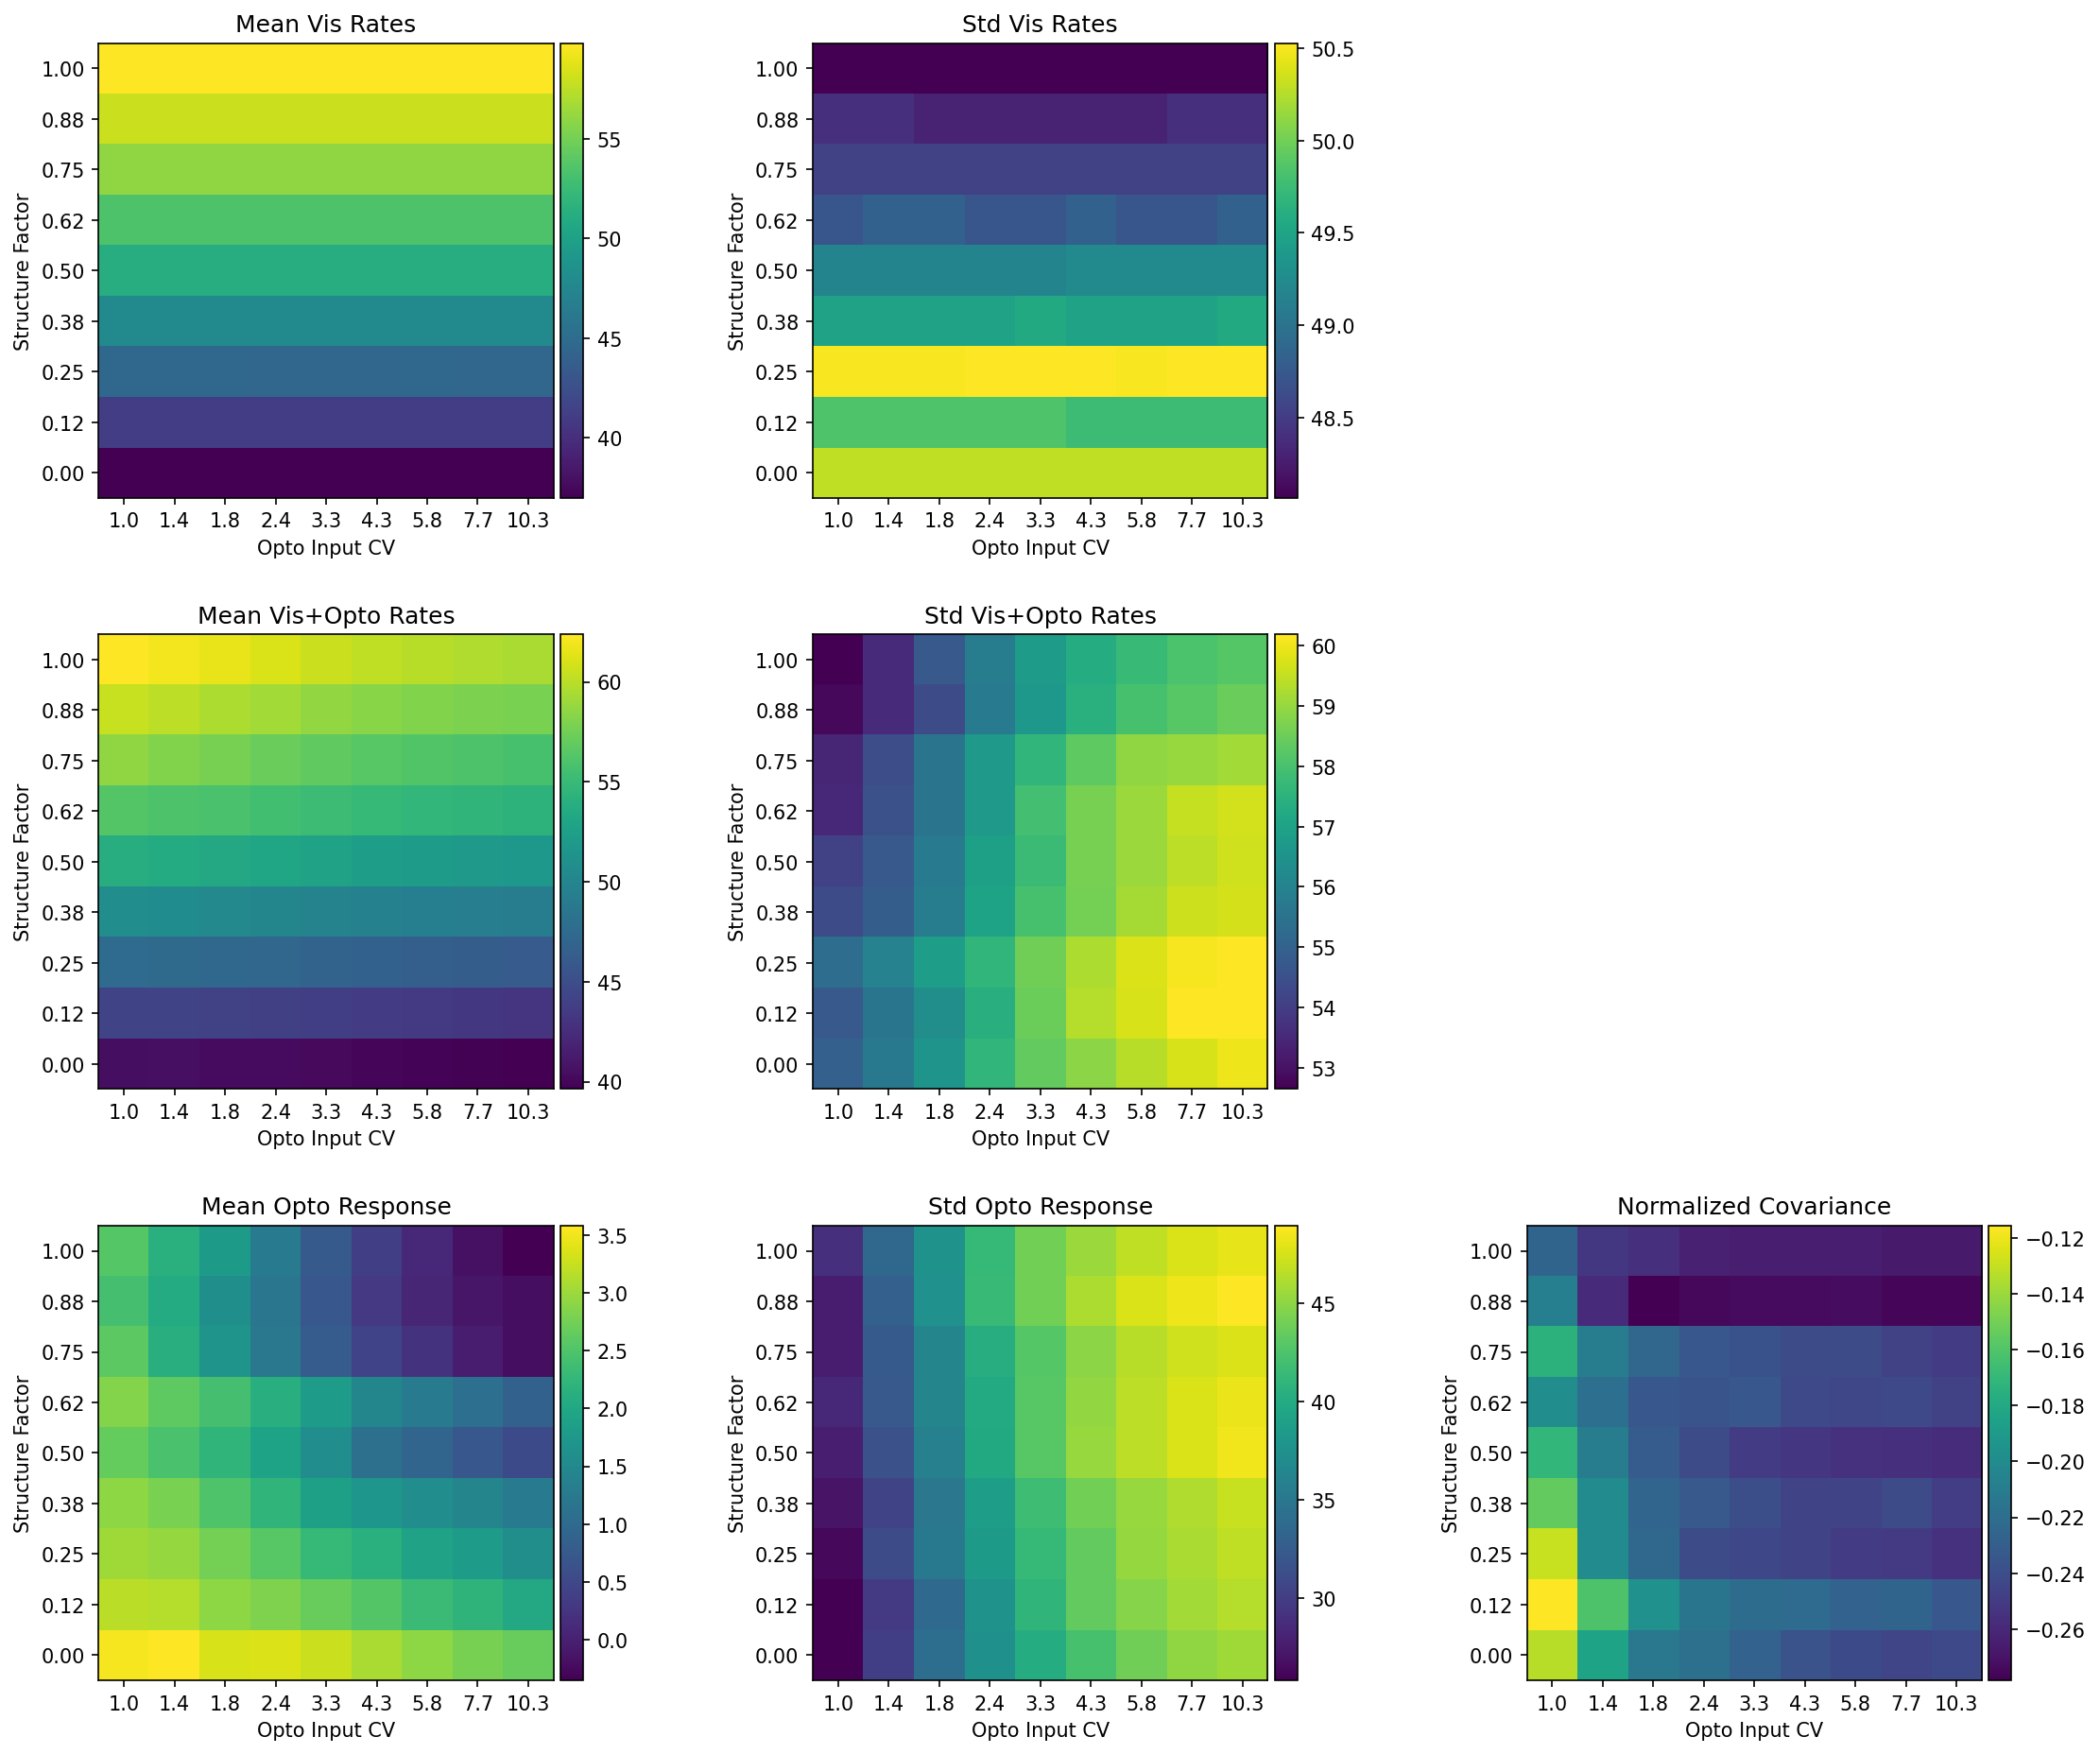

In [18]:
fig,axs = plt.subplots(3,3,figsize=(18,15),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

imshowbar(fig,axs[0,0],sim_vsm_base_means,origin='lower')
imshowbar(fig,axs[0,1],sim_vsm_base_stds,origin='lower')
imshowbar(fig,axs[1,0],sim_vsm_opto_means,origin='lower')
imshowbar(fig,axs[1,1],sim_vsm_opto_stds,origin='lower')
imshowbar(fig,axs[2,0],sim_vsm_diff_means,origin='lower')
imshowbar(fig,axs[2,1],sim_vsm_diff_stds,origin='lower')
imshowbar(fig,axs[2,2],sim_vsm_norm_covs,origin='lower')

axs[0,0].set_title('Mean Vis Rates')
axs[0,1].set_title('Std Vis Rates')
axs[1,0].set_title('Mean Vis+Opto Rates')
axs[1,1].set_title('Std Vis+Opto Rates')
axs[2,0].set_title('Mean Opto Response')
axs[2,1].set_title('Std Opto Response')
axs[2,2].set_title('Normalized Covariance')

for i in range(3):
    for j in range(3):
        if i < 2 and j == 2:
            axs[i,j].axis('off')
        else:
            # axs[i,j].contour(sim_Lexps[:,:,0],[0],colors='w',linestyles='-')
            # axs[i,j].contourf(sim_Lexps[:,:,0],[0,1e12],colors='w',linestyles='-',alpha=0.2)
            # axs[i,j].contour(sim_Lexps[:,:,1],[0],colors='w',linestyles='--')
            # axs[i,j].contourf(sim_Lexps[:,:,1],[0,1e12],colors='w',linestyles='--',alpha=0.2)
            
            axs[i,j].set_xticks(np.arange(len(CVLs)),['{:.1f}'.format(CVL) for CVL in CVLs],
                                fontsize=10)
            axs[i,j].set_yticks(np.arange(len(structs)),['{:.2f}'.format(struct) for struct in structs],
                                fontsize=10)

            axs[i,j].set_xlabel('Opto Input CV')
            axs[i,j].set_ylabel('Structure Factor')

In [ ]:
print(sim_vsm_diff_means[-1,:])
print(sim_vsm_diff_stds[-1,:])
print(sim_vsm_norm_covs[-1,:])

In [ ]:
with open('./../results/best_fit.pkl', 'wb') as handle:
    fit_prms = fit_res_dict['prms']
    fit_prms['CVL'] = CVLs[-3]
    fit_eX = fit_res_dict['best_monk_eX']
    fit_bX = fit_res_dict['best_monk_bX']
    fit_aXs = fit_res_dict['best_monk_aXs']
    this_dict = {'prms'          : fit_prms,
                 'best_monk_eX'  : fit_eX,
                 'best_monk_bX'  : fit_bX,
                 'best_monk_aXs' : fit_aXs}
    
    pickle.dump(this_dict,handle)

In [ ]:
fig,axs = plt.subplots(3,1,figsize=(2.5,6),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

cbar = imshowbar(fig,axs[0],sim_vsm_diff_means,origin='lower')
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[1],sim_vsm_diff_stds,origin='lower')
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[2],sim_vsm_norm_covs,origin='lower')
cbar.ax.tick_params(labelsize=12)

axs[0].set_title(r'Mean $\Delta$rate (spk/s)',fontsize=12)
axs[1].set_title(r'Std $\Delta$rate (spk/s)',fontsize=12)
axs[2].set_title(r'$\rho$',fontsize=12)

for i in range(3):
    axs[i].set_xticks(np.arange(0,len(CVLs),4),['{:.1f}'.format(CVL) for CVL in 10**(np.arange(0,8+1)/8-0.5)[::4]],
                        fontsize=12)
    axs[i].set_yticks(np.arange(0,len(structs),4),['{:d}'.format(int(struct*100)) for struct in structs[::4]],
                        fontsize=12)

    axs[i].set_xlabel(r'Opto Input CV Multiplier',fontsize=12)
    axs[i].set_ylabel('Structure (%)',fontsize=12)

fig.tight_layout()
fig.savefig('../plots'+'/varied_struct_CVL.pdf', bbox_inches='tight')

In [19]:
structs = np.arange(0,8+1)/8
rXs = bX*10**(np.arange(0,8+1)/8-0.5)
Js = prms['J']*10**(np.arange(0,8+1)/8-0.5)
CVLs = prms['CVL']*10**(np.arange(0,8+1)/8-0.5)

rX_osm_diff_means = np.zeros((len(structs),len(rXs)))
rX_vsm_diff_means = np.zeros((len(structs),len(rXs)))
rX_vsm_diff_stds = np.zeros((len(structs),len(rXs)))
rX_vsm_norm_covs = np.zeros((len(structs),len(rXs)))

J_osm_diff_means = np.zeros((len(structs),len(Js)))
J_vsm_diff_means = np.zeros((len(structs),len(Js)))
J_vsm_diff_stds = np.zeros((len(structs),len(Js)))
J_vsm_norm_covs = np.zeros((len(structs),len(Js)))

CVL_osm_diff_means = np.zeros((len(structs),len(CVLs)))
CVL_vsm_diff_means = np.zeros((len(structs),len(CVLs)))
CVL_vsm_diff_stds = np.zeros((len(structs),len(CVLs)))
CVL_vsm_norm_covs = np.zeros((len(structs),len(CVLs)))

for struct_idx,struct in enumerate(structs):
    for rX_idx,rX in enumerate(rXs):
        with open('./../results/vary_id_None_struct_{:d}_rX_{:d}'.format(struct_idx,rX_idx)+'.pkl', 'rb') as\
                handle:
            res_dict = pickle.load(handle)
        rX_osm_diff_means[struct_idx,rX_idx] = res_dict['osm_diff_means']
        rX_vsm_diff_means[struct_idx,rX_idx] = res_dict['vsm_diff_means']
        rX_vsm_diff_stds[struct_idx,rX_idx] = res_dict['vsm_diff_stds']
        rX_vsm_norm_covs[struct_idx,rX_idx] = res_dict['vsm_norm_covs']

for struct_idx,struct in enumerate(structs):
    for J_idx,J in enumerate(Js):
        with open('./../results/vary_id_None_struct_{:d}_J_{:d}'.format(struct_idx,J_idx)+'.pkl', 'rb') as\
                handle:
            res_dict = pickle.load(handle)
        J_osm_diff_means[struct_idx,J_idx] = res_dict['osm_diff_means']
        J_vsm_diff_means[struct_idx,J_idx] = res_dict['vsm_diff_means']
        J_vsm_diff_stds[struct_idx,J_idx] = res_dict['vsm_diff_stds']
        J_vsm_norm_covs[struct_idx,J_idx] = res_dict['vsm_norm_covs']

for struct_idx,struct in enumerate(structs):
    for CVL_idx,CVL in enumerate(CVLs):
        with open('./../results/vary_id_None_struct_{:d}_CVL_{:d}'.format(struct_idx,CVL_idx)+'.pkl', 'rb') as\
                handle:
            res_dict = pickle.load(handle)
        CVL_osm_diff_means[struct_idx,CVL_idx] = res_dict['osm_diff_means']
        CVL_vsm_diff_means[struct_idx,CVL_idx] = res_dict['vsm_diff_means']
        CVL_vsm_diff_stds[struct_idx,CVL_idx] = res_dict['vsm_diff_stds']
        CVL_vsm_norm_covs[struct_idx,CVL_idx] = res_dict['vsm_norm_covs']

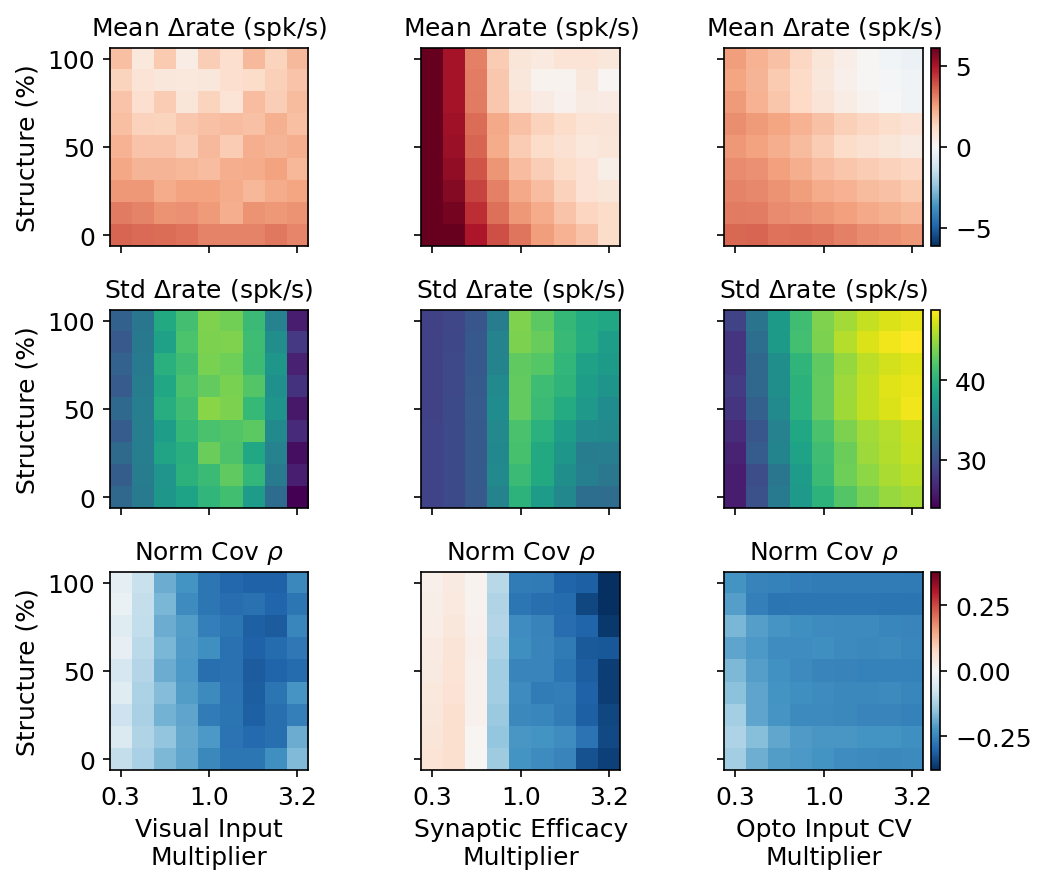

In [20]:
fig,axs = plt.subplots(3,3,figsize=(2.5*3,2*3),dpi=150,sharey=True,sharex='col')#,width_ratios=[3,3,4])
fig.subplots_adjust(wspace=0.3,hspace=0.3)

diff_mean_lim = np.max(np.abs(np.concatenate((rX_vsm_diff_means.flatten(),J_vsm_diff_means[:,1:].flatten(),CVL_vsm_diff_means.flatten()))))
diff_std_lolim = np.min(np.concatenate((rX_vsm_diff_stds.flatten(),J_vsm_diff_stds.flatten(),CVL_vsm_diff_stds.flatten())))
diff_std_uplim = np.max(np.concatenate((rX_vsm_diff_stds.flatten(),J_vsm_diff_stds.flatten(),CVL_vsm_diff_stds.flatten())))
norm_cov_lim = np.max(np.abs(np.concatenate((rX_vsm_norm_covs.flatten(),J_vsm_norm_covs.flatten(),CVL_vsm_norm_covs.flatten()))))

# cbar = imshowbar(fig,axs[0,0],rX_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
axs[0,0].imshow(rX_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[1,0],rX_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
axs[1,0].imshow(rX_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[2,0],rX_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
axs[2,0].imshow(rX_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
# cbar.ax.tick_params(labelsize=12)

# cbar = imshowbar(fig,axs[0,1],J_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
axs[0,1].imshow(J_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[1,1],J_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
axs[1,1].imshow(J_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[2,1],J_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
axs[2,1].imshow(J_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
# cbar.ax.tick_params(labelsize=12)

cbar = imshowbar(fig,axs[0,2],CVL_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[1,2],CVL_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[2,2],CVL_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
cbar.ax.tick_params(labelsize=12)

axs[2,0].set_xlabel('Visual Input\nMultiplier',fontsize=12)
axs[2,1].set_xlabel('Synaptic Efficacy\nMultiplier',fontsize=12)
axs[2,2].set_xlabel('Opto Input CV\nMultiplier',fontsize=12)

for i in range(3):
    axs[2,i].set_xticks(np.arange(0,9,4),['{:.1f}'.format(x) for x in 10**(np.arange(0,8+1)/8-0.5)[::4]],
                        fontsize=12)
    axs[i,0].set_yticks(np.arange(0,len(structs),4),['{:d}'.format(int(struct*100)) for struct in structs[::4]],
                        fontsize=12)
    axs[i,0].set_ylabel('Structure (%)',fontsize=12)

    axs[0,i].set_title(r'Mean $\Delta$rate (spk/s)',fontsize=12)
    axs[1,i].set_title(r'Std $\Delta$rate (spk/s)',fontsize=12)
    axs[2,i].set_title(r'Norm Cov $\rho$',fontsize=12)

fig.tight_layout()
fig.savefig('../plots'+'/varied_struct_all.pdf', bbox_inches='tight')

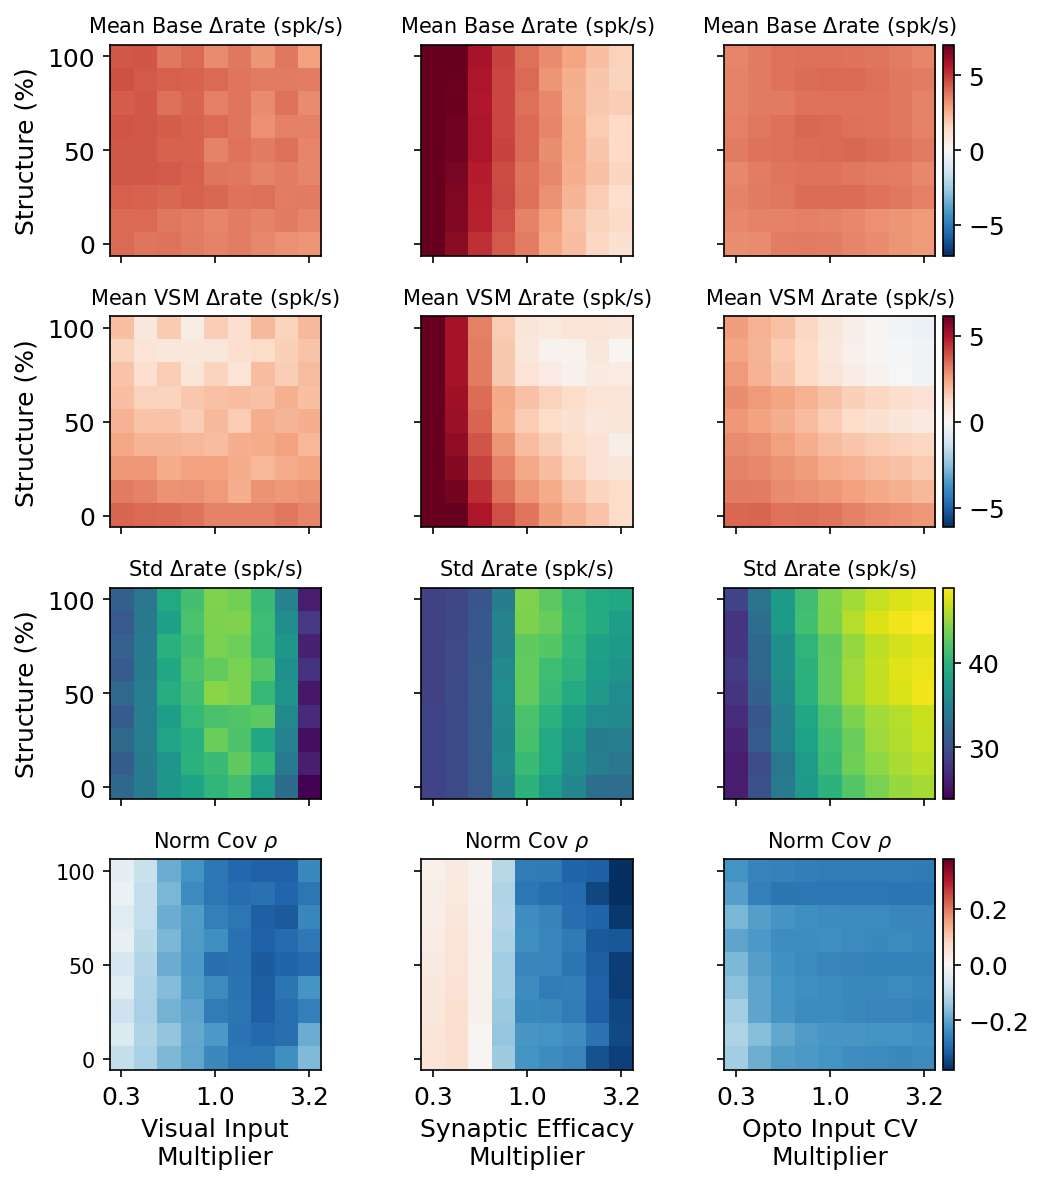

In [21]:
fig,axs = plt.subplots(4,3,figsize=(2.5*3,2*4),dpi=150,sharey=True,sharex='col')#,width_ratios=[3,3,4])
fig.subplots_adjust(wspace=0.3,hspace=0.3)

osm_diff_mean_lim = np.max(np.abs(np.concatenate((rX_osm_diff_means.flatten(),J_osm_diff_means[:,1:].flatten(),CVL_osm_diff_means.flatten()))))
diff_mean_lim = np.max(np.abs(np.concatenate((rX_vsm_diff_means.flatten(),J_vsm_diff_means[:,1:].flatten(),CVL_vsm_diff_means.flatten()))))
diff_std_lolim = np.min(np.concatenate((rX_vsm_diff_stds.flatten(),J_vsm_diff_stds.flatten(),CVL_vsm_diff_stds.flatten())))
diff_std_uplim = np.max(np.concatenate((rX_vsm_diff_stds.flatten(),J_vsm_diff_stds.flatten(),CVL_vsm_diff_stds.flatten())))
norm_cov_lim = np.max(np.abs(np.concatenate((rX_vsm_norm_covs.flatten(),J_vsm_norm_covs.flatten(),CVL_vsm_norm_covs.flatten()))))

# cbar = imshowbar(fig,axs[0,0],rX_osm_diff_means,origin='lower',cmap='RdBu_r',vmin=-osm_diff_mean_lim,vmax=osm_diff_mean_lim)
axs[0,0].imshow(rX_osm_diff_means,origin='lower',cmap='RdBu_r',vmin=-osm_diff_mean_lim,vmax=osm_diff_mean_lim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[1,0],rX_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
axs[1,0].imshow(rX_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[2,0],rX_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
axs[2,0].imshow(rX_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[3,0],rX_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
axs[3,0].imshow(rX_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
# cbar.ax.tick_params(labelsize=12)

# cbar = imshowbar(fig,axs[0,1],J_osm_diff_means,origin='lower',cmap='RdBu_r',vmin=-osm_diff_mean_lim,vmax=osm_diff_mean_lim)
axs[0,1].imshow(J_osm_diff_means,origin='lower',cmap='RdBu_r',vmin=-osm_diff_mean_lim,vmax=osm_diff_mean_lim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[1,1],J_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
axs[1,1].imshow(J_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[2,1],J_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
axs[2,1].imshow(J_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[3,1],J_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
axs[3,1].imshow(J_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
# cbar.ax.tick_params(labelsize=12)

cbar = imshowbar(fig,axs[0,2],CVL_osm_diff_means,origin='lower',cmap='RdBu_r',vmin=-osm_diff_mean_lim,vmax=osm_diff_mean_lim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[1,2],CVL_vsm_diff_means,origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[2,2],CVL_vsm_diff_stds,origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[3,2],CVL_vsm_norm_covs,origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
cbar.ax.tick_params(labelsize=12)

axs[3,0].set_xlabel('Visual Input\nMultiplier',fontsize=12)
axs[3,1].set_xlabel('Synaptic Efficacy\nMultiplier',fontsize=12)
axs[3,2].set_xlabel('Opto Input CV\nMultiplier',fontsize=12)

for i in range(3):
    axs[3,i].set_xticks(np.arange(0,9,4),['{:.1f}'.format(x) for x in 10**(np.arange(0,8+1)/8-0.5)[::4]],
                        fontsize=12)
    axs[i,0].set_yticks(np.arange(0,len(structs),4),['{:d}'.format(int(struct*100)) for struct in structs[::4]],
                        fontsize=12)
    axs[i,0].set_ylabel('Structure (%)',fontsize=12)

    axs[0,i].set_title(r'Mean Base $\Delta$rate (spk/s)',fontsize=10)
    axs[1,i].set_title(r'Mean VSM $\Delta$rate (spk/s)',fontsize=10)
    axs[2,i].set_title(r'Std $\Delta$rate (spk/s)',fontsize=10)
    axs[3,i].set_title(r'Norm Cov $\rho$',fontsize=10)

fig.tight_layout()
fig.savefig('../plots'+'/varied_struct_all.pdf', bbox_inches='tight')

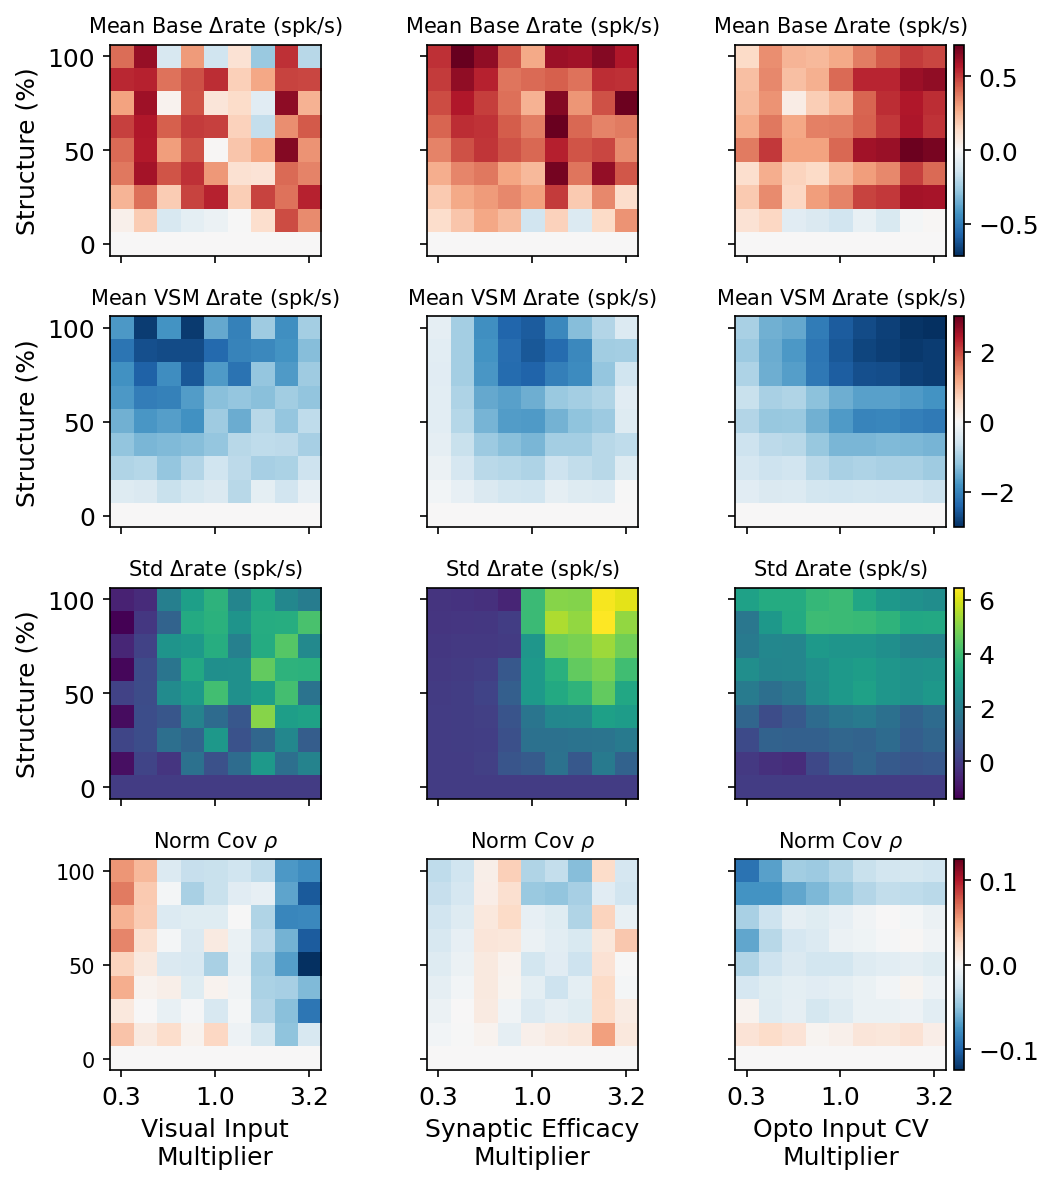

In [22]:
fig,axs = plt.subplots(4,3,figsize=(2.5*3,2*4),dpi=150,sharey=True,sharex='col')#,width_ratios=[3,3,4])
fig.subplots_adjust(wspace=0.3,hspace=0.3)

osm_diff_mean_lim = np.max(np.abs(np.concatenate(((rX_osm_diff_means-rX_osm_diff_means[0:1,:]).flatten(),(J_osm_diff_means-J_osm_diff_means[0:1,:]).flatten(),(CVL_osm_diff_means-CVL_osm_diff_means[0:1,:]).flatten()))))
diff_mean_lim = np.max(np.abs(np.concatenate(((rX_vsm_diff_means-rX_vsm_diff_means[0:1,:]).flatten(),(J_vsm_diff_means-J_vsm_diff_means[0:1,:]).flatten(),(CVL_vsm_diff_means-CVL_vsm_diff_means[0:1,:]).flatten()))))
diff_std_lolim = np.min(np.concatenate(((rX_vsm_diff_stds-rX_vsm_diff_stds[0:1,:]).flatten(),(J_vsm_diff_stds-J_vsm_diff_stds[0:1,:]).flatten(),(CVL_vsm_diff_stds-CVL_vsm_diff_stds[0:1,:]).flatten())))
diff_std_uplim = np.max(np.concatenate(((rX_vsm_diff_stds-rX_vsm_diff_stds[0:1,:]).flatten(),(J_vsm_diff_stds-J_vsm_diff_stds[0:1,:]).flatten(),(CVL_vsm_diff_stds-CVL_vsm_diff_stds[0:1,:]).flatten())))
norm_cov_lim = np.max(np.abs(np.concatenate(((rX_vsm_norm_covs-rX_vsm_norm_covs[0:1,:]).flatten(),(J_vsm_norm_covs-J_vsm_norm_covs[0:1,:]).flatten(),(CVL_vsm_norm_covs-CVL_vsm_norm_covs[0:1,:]).flatten()))))

# cbar = imshowbar(fig,axs[0,0],rX_osm_diff_means-rX_osm_diff_means[0:1,:],origin='lower',cmap='RdBu_r',vmin=-osm_diff_mean_lim,vmax=osm_diff_mean_lim)
axs[0,0].imshow(rX_osm_diff_means-rX_osm_diff_means[0:1,:],origin='lower',cmap='RdBu_r',vmin=-osm_diff_mean_lim,vmax=osm_diff_mean_lim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[1,0],rX_vsm_diff_means-rX_vsm_diff_means[0:1,:],origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
axs[1,0].imshow(rX_vsm_diff_means-rX_vsm_diff_means[0:1,:],origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[2,0],rX_vsm_diff_stds-rX_vsm_diff_stds[0:1,:],origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
axs[2,0].imshow(rX_vsm_diff_stds-rX_vsm_diff_stds[0:1,:],origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[3,0],rX_vsm_norm_covs-rX_vsm_norm_covs[0:1,:],origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
axs[3,0].imshow(rX_vsm_norm_covs-rX_vsm_norm_covs[0:1,:],origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
# cbar.ax.tick_params(labelsize=12)

# cbar = imshowbar(fig,axs[0,1],J_osm_diff_means-J_osm_diff_means[0:1,:],origin='lower',cmap='RdBu_r',vmin=-osm_diff_mean_lim,vmax=osm_diff_mean_lim)
axs[0,1].imshow(J_osm_diff_means-J_osm_diff_means[0:1,:],origin='lower',cmap='RdBu_r',vmin=-osm_diff_mean_lim,vmax=osm_diff_mean_lim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[1,1],J_vsm_diff_means-J_vsm_diff_means[0:1,:],origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
axs[1,1].imshow(J_vsm_diff_means-J_vsm_diff_means[0:1,:],origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[2,1],J_vsm_diff_stds-J_vsm_diff_stds[0:1,:],origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
axs[2,1].imshow(J_vsm_diff_stds-J_vsm_diff_stds[0:1,:],origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
# cbar.ax.tick_params(labelsize=12)
# cbar = imshowbar(fig,axs[3,1],J_vsm_norm_covs-J_vsm_norm_covs[0:1,:],origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
axs[3,1].imshow(J_vsm_norm_covs-J_vsm_norm_covs[0:1,:],origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
# cbar.ax.tick_params(labelsize=12)

cbar = imshowbar(fig,axs[0,2],CVL_osm_diff_means-CVL_osm_diff_means[0:1,:],origin='lower',cmap='RdBu_r',vmin=-osm_diff_mean_lim,vmax=osm_diff_mean_lim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[1,2],CVL_vsm_diff_means-CVL_vsm_diff_means[0:1,:],origin='lower',cmap='RdBu_r',vmin=-diff_mean_lim,vmax=diff_mean_lim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[2,2],CVL_vsm_diff_stds-CVL_vsm_diff_stds[0:1,:],origin='lower',vmin=diff_std_lolim,vmax=diff_std_uplim)
cbar.ax.tick_params(labelsize=12)
cbar = imshowbar(fig,axs[3,2],CVL_vsm_norm_covs-CVL_vsm_norm_covs[0:1,:],origin='lower',cmap='RdBu_r',vmin=-norm_cov_lim,vmax=norm_cov_lim)
cbar.ax.tick_params(labelsize=12)

axs[3,0].set_xlabel('Visual Input\nMultiplier',fontsize=12)
axs[3,1].set_xlabel('Synaptic Efficacy\nMultiplier',fontsize=12)
axs[3,2].set_xlabel('Opto Input CV\nMultiplier',fontsize=12)

for i in range(3):
    axs[3,i].set_xticks(np.arange(0,9,4),['{:.1f}'.format(x) for x in 10**(np.arange(0,8+1)/8-0.5)[::4]],
                        fontsize=12)
    axs[i,0].set_yticks(np.arange(0,len(structs),4),['{:d}'.format(int(struct*100)) for struct in structs[::4]],
                        fontsize=12)
    axs[i,0].set_ylabel('Structure (%)',fontsize=12)

    axs[0,i].set_title(r'Mean Base $\Delta$rate (spk/s)',fontsize=10)
    axs[1,i].set_title(r'Mean VSM $\Delta$rate (spk/s)',fontsize=10)
    axs[2,i].set_title(r'Std $\Delta$rate (spk/s)',fontsize=10)
    axs[3,i].set_title(r'Norm Cov $\rho$',fontsize=10)

fig.tight_layout()
fig.savefig('../plots'+'/varied_struct_all.pdf', bbox_inches='tight')